This is my attempt at using the logistic regression to calculate propensity score. The data are normalized. 

In [1]:
%matplotlib inline
import math
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from scipy.stats import binom, hypergeom, gaussian_kde
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from scipy.stats import ttest_ind
from scipy.stats import ranksums
from scipy import stats

In [2]:
def create_throwaway_df(dataframe):
    dataframe['body'] = dataframe['body'].str.lower()
    dataframe['author'] = dataframe['author'].str.lower()
    dataframe['ThrowAuth'] = dataframe.author.str.contains('thrw|throwaway|throw|thrw|thraway', na=False)

    dataframe['ThrowBody'] = dataframe.body.str.match('this is a throwaway|I am using a throwaway|I\'m using a throwawy')

    return dataframe

In [3]:
def create_two_gender_df(dataframe):
    
    dataframe['Gendered'] = (dataframe.DadBody>0) | (dataframe.DadAuthor>0) | (dataframe.MomBody>0) | (dataframe.MomAuthor>0)
    
    return dataframe

In [4]:
def create_mom(dataframe):
    
    dataframe['MomBody'] = dataframe.body.str.match('I\'m a mum|I am a mum|mum here|mom here|I am a mom|I\'m a mom|I am a mother|mother here|I\'m a mother| I am a stay-at-home mom|I\'m a stay-at-home mom|I was a stay-at-home mom|I was a sahm')
    dataframe['MomAuthor'] = dataframe.author.str.contains('mom|mother|mama|mum', na=False)

    
    return dataframe

In [5]:
def create_dad(dataframe):
    
    dataframe['DadBody']= dataframe.body.str.match('dad here|I am a dad|I\'m a dad|I am a father|father here|I\'m a father|I am a SAHD|I`m a SAHD|I was a SAHD|I am a stay-at-home father|I\'m a stay-at-home father|I was a stay-at-home father|I was a stay-at-home dad|I was a sahd')
    dataframe['DadAuthor'] = dataframe.author.str.contains('dad|daddy|dada|father', na=False)
    
    return dataframe

In [169]:
def get_name(dataframe, author_name):
    return dataframe[dataframe['author']==author_name].name

def get_list_of_names(dataframe, list_of_authors):
    list_of_names = []
    for i in range(0, len(list_of_authors)):
        current_name = get_name(dataframe, list_of_authors[i])
        list_of_names.append(current_name)
    return list_of_names

#The function returns replies when the parent_id is the same 
#as the name from an earlier commenter
#This would allow me to find the comment replies to the same
#depth in the subreddit. 
#This works if the response is a pandas series
def get_replies(dataframe, comment_list):
    dataframe_list = []
    for i in range(0, len(comment_list)):
        for j in range(0, len(comment_list[i])):
            dataframe_list.append(dataframe[dataframe['parent_id']==comment_list[i].values[j]])
    return pd.concat(dataframe_list), dataframe

In [7]:
#Prepare the IV's from dataframe
#add throwaway variable
def prepare_data_for_models(dataframe):
    dataframe_piv = pd.pivot_table(dataframe, index= 'author', aggfunc= 'mean')
    #setting the users of more than one subreddit
    #for example, only r/Daddit and r/Mommit
    dataframe_piv['DM'] =  (dataframe_piv.daddit>0) & (dataframe_piv.Mommit>0) & (dataframe_piv.Parenting==0)
    dataframe_piv['PD'] =  (dataframe_piv.Parenting>0) & (dataframe_piv.daddit>0) & (dataframe_piv.Mommit==0)
    dataframe_piv['PM'] =  (dataframe_piv.Parenting>0) & (dataframe_piv.Mommit>0) & (dataframe_piv.daddit==0)
    dataframe_piv['PMD'] =  (dataframe_piv.daddit>0) & (dataframe_piv.Mommit>0) & (dataframe_piv.Parenting>0)
    
    dataframe_piv['Dad'] = (dataframe_piv.DadBody>0) | (dataframe_piv.DadAuthor>0)
    dataframe_piv['Dad'] = dataframe_piv['Dad']*1
    dataframe_piv['Dad'].fillna(0, inplace=True)
    dataframe_piv['Dad'] = dataframe_piv['Dad'].astype('int')
    
    dataframe_piv['Mom'] = (dataframe_piv.MomBody>0) | (dataframe_piv.MomAuthor>0)
    dataframe_piv['Mom'] = dataframe_piv['Mom']*1
    dataframe_piv['Mom'].fillna(0, inplace=True)
    dataframe_piv['Mom'] = dataframe_piv['Mom'].astype('int')
    
    dataframe_piv['Gendered'] = (dataframe_piv.Mom>0) ^ (dataframe_piv.Dad>0)
    
    #dataframe_piv['Gendered'] = dataframe_piv.mask(dataframe_piv.Gendered>0)
    dataframe_piv['Gendered'] = dataframe_piv['Gendered']*1
    dataframe_piv['Gendered'].fillna(0, inplace=True)
    dataframe_piv['Gendered'] = dataframe_piv['Gendered'].astype('int')
    
        
    dataframe_piv['Throwaway'] = (dataframe_piv.ThrowAuth>0) | (dataframe_piv.ThrowBody>0)
    
    dataframe_piv['Throwaway'] = dataframe_piv['Throwaway']*1
    dataframe_piv['Throwaway'].fillna(0, inplace=True)
    dataframe_piv['Throwaway'] = dataframe_piv['Throwaway'].astype('int')
    
    return dataframe_piv

In [8]:
#I have modified some work done before on the subject
#Source: https://github.com/kellieotto/StatMoments/blob/master/PSM_complete.ipynb
def Match(groups, propensity, caliper = 0.05, caliper_method = "propensity", replace = False):
    ''' 
    Implements greedy one-to-one matching on propensity scores.
    
    Inputs:
    groups = Array-like object of treatment assignments.  Must be 2 groups
    propensity = Array-like object containing propensity scores for each observation. Propensity and groups should be in the same order (matching indices)
    caliper = a numeric value, specifies maximum distance (difference in propensity scores or SD of logit propensity) 
    caliper_method = a string: "propensity" (default) if caliper is a maximum difference in propensity scores,
            "logit" if caliper is a maximum SD of logit propensity, or "none" for no caliper
    replace = Logical for whether individuals from the larger group should be allowed to match multiple individuals in the smaller group.
        (default is False)
    
    Output:
    A series containing the individuals in the control group matched to the treatment group.
    Note that with caliper matching, not every treated individual may have a match.
    '''

    # Check inputs
    if any(propensity <=0) or any(propensity >=1):
        raise ValueError('Propensity scores must be between 0 and 1')
    elif not(0<=caliper<1):
        if caliper_method == "propensity" and caliper>1:
            raise ValueError('Caliper for "propensity" method must be between 0 and 1')
        elif caliper<0:
            raise ValueError('Caliper cannot be negative')
    elif len(groups)!= len(propensity):
        raise ValueError('groups and propensity scores must be same dimension')
    elif len(groups.unique()) != 2:
        raise ValueError('wrong number of groups: expected 2')
        
    
    # Transform the propensity scores and caliper when caliper_method is "logit" or "none"
    if caliper_method == "logit":
        propensity = log(propensity/(1-propensity))
        caliper = caliper*np.std(propensity)
    elif caliper_method == "none":
        caliper = 0
    
    # Code groups as 0 and 1
    groups = groups == groups.unique()[0]
    N = len(groups)
    N1 = groups[groups == 1].index; N2 = groups[groups == 0].index
    g1, g2 = propensity[groups == 1], propensity[groups == 0]
    # Check if treatment groups got flipped - the smaller should correspond to N1/g1
    if len(N1) > len(N2):
       N1, N2, g1, g2 = N2, N1, g2, g1
        
        
    # Randomly permute the smaller group to get order for matching
    morder = np.random.permutation(N1)
    matches = {}

    
    for m in morder:
        dist = abs(g1[m] - g2)
        if (dist.min() <= caliper) or not caliper:
            matches[m] = dist.argmin()    # Potential problem: check for ties
            if not replace:
                g2 = g2.drop(matches[m])
    return (matches)



def MatchMany(groups, propensity, method = "caliper", k = 1, caliper = 0.05, caliper_method = "propensity", replace = True):
    ''' 
    Implements greedy one-to-many matching on propensity scores.
    
    Inputs:
    groups = Array-like object of treatment assignments.  Must be 2 groups
    propensity = Array-like object containing propensity scores for each observation. Propensity and groups should be in the same order (matching indices)
    method = a string: "caliper" (default) to select all matches within a given range, "knn" for k nearest neighbors,
    k = an integer (default is 1). If method is "knn", this specifies the k in k nearest neighbors
    caliper = a numeric value, specifies maximum distance (difference in propensity scores or SD of logit propensity) 
    caliper_method = a string: "propensity" (default) if caliper is a maximum difference in propensity scores,
            "logit" if caliper is a maximum SD of logit propensity, or "none" for no caliper
    replace = Logical for whether individuals from the larger group should be allowed to match multiple individuals in the smaller group.
        (default is True)
    
    Output:
    A series containing the individuals in the control group matched to the treatment group.
    Note that with caliper matching, not every treated individual may have a match within calipers.
        In that case we match it to its single nearest neighbor.  The alternative is to throw out individuals with no matches, but then we'd no longer be estimating the ATT.
    '''

    # Check inputs
    if any(propensity <=0) or any(propensity >=1):
        raise ValueError('Propensity scores must be between 0 and 1')
    elif not(0<=caliper<1):
        if caliper_method == "propensity" and caliper>1:
            raise ValueError('Caliper for "propensity" method must be between 0 and 1')
        elif caliper<0:
            raise ValueError('Caliper cannot be negative')
    elif len(groups)!= len(propensity):
        raise ValueError('groups and propensity scores must be same dimension')
    elif len(groups.unique()) != 2:
        raise ValueError('wrong number of groups: expected 2')
        
    
    # Transform the propensity scores and caliper when caliper_method is "logit" or "none"
    if method == "caliper":
        if caliper_method == "logit":
            propensity = log(propensity/(1-propensity))
            caliper = caliper*np.std(propensity)
        elif caliper_method == "none":
            caliper = 0
    
    # Code groups as 0 and 1
    groups = groups == groups.unique()[0]
    N = len(groups)
    N1 = groups[groups == 1].index; N2 = groups[groups == 0].index
    g1, g2 = propensity[groups == 1], propensity[groups == 0]
    # Check if treatment groups got flipped - the smaller should correspond to N1/g1
    if len(N1) > len(N2):
       N1, N2, g1, g2 = N2, N1, g2, g1
        
        
    # Randomly permute the smaller group to get order for matching
    morder = np.random.permutation(N1)
    matches = {}
    
    for m in morder:
        dist = abs(g1[m] - g2)
        dist.sort()
        if method == "knn":
            caliper = dist.iloc[k-1]
        # PROBLEM: when there are ties in the knn. 
        # Need to randomly select among the observations tied for the farthest eacceptable distance
        keep = np.array(dist[dist<=caliper].index)
        if len(keep):
            matches[m] = keep
        else:
            matches[m] = [dist.argmin()]
        if not replace:
            g2 = g2.drop(matches[m])
    return (matches)


    
def whichMatched(matches, data, many = False, unique = False):
    ''' 
    Simple function to convert output of Matches to DataFrame of all matched observations
    Inputs:
    matches = output of Match
    data = DataFrame of covariates
    many = Boolean indicating if matching method is one-to-one or one-to-many
    unique = Boolean indicating if duplicated individuals (ie controls matched to more than one case) should be removed
    '''

    tr = matches.keys()
    if many:
        ctrl = [m for matchset in matches.values() for m in matchset]
    else:
        ctrl = matches.values()
    # need to remove duplicate rows, which may occur in matching with replacement
    temp = pd.concat([data.ix[tr], data.ix[ctrl]])
    if unique == True:
        return temp.groupby(temp.index).first()
    else:
        return temp

In [9]:
def averageTreatmentEffect(groups, response, matches):
    '''
    Computes ATT using difference in means.
    The data passed in should already have unmatched individuals and duplicates removed.

    Inputs:
    groups = Series containing treatment assignment. Must be 2 groups
    response = Series containing response measurements. Indices should match those of groups.
    matches = output of Match or MatchMany
    '''
    if len(groups.unique()) != 2:
        raise ValueError('wrong number of groups: expected 2')
    
    groups = (groups == groups.unique()[0])
    response = response.groupby(response.index).first()
    response1 = []; response0 = []
    for k in matches.keys():
        response1.append(response[k])
        response0.append( (response[matches[k]]).mean() )   # Take mean response of controls matched to treated individual k
    return np.array(response1).mean(), np.array(response0).mean(),np.array(response1).mean() - np.array(response0).mean()



In [10]:
def Balance(groups, covariates):
    '''
    Computes absolute difference of means and standard error for covariates by group
    '''
    means = covariates.groupby(groups).mean()
    dist = abs(means.diff()).ix[1]
    std = covariates.groupby(groups).std()
    n = groups.value_counts()
    se = std.apply(lambda s: np.sqrt(s[0]**2/n[0] + s[1]**2/n[1]))
    return dist, se

def plot_balance(matches, covariates, test=['t', 'rank'], notebook=False, filename='balance-plot',
                     **kwargs):
        """
        Plot the p-values for covariate balance before and after matching
        Parameters
        ----------
        matches : Match
            Match class object with matches already fit
        covariates : DataFrame 
            Dataframe for with all observations and one covariate per column.
        test : array-like or str
            Statistical test to compare treatment and control covariate distributions.
            Options are 't' for a two sample t-test or 'rank' for Wilcoxon rank sum test
        notebook : bool
            Optional, plot inline in a Jupyter notebook? Default False
        filename : str
            Optional, name of file to save plot in. Default 'balance-plot'
        kwargs : dict
            Key word arguments to pass into plotly.offline.plot
        Returns
        -------
        None
        Notes
        -----
        Creates a file with given filename
        """

        # check valid test inputs
        test = list(test)
        extra = set(test) - set(['t', 'rank'])
        if len(extra) > 0:
            raise ValueError('unidentified test was supplied')
    
        # use matches to create covariate and tr dataframes
        covnames = list(covariates.columns)
        matched_c = whichMatched(matches, covariates, show_duplicates=True)[covnames]
        matched_g = whichMatched(matches, matches.groups, show_duplicates=True)
    
        trace0_t = None
        trace1_t = None
        trace0_rank = None
        trace1_rank = None
        # run tests, get pvalues
        if 't' in test:
            pvalues_before_t = t_test(covariates, matches.groups)
            pvalues_after_t = t_test(matched_c, matched_g)
            trace0_t = go.Scatter(
                x=pvalues_before_t,
                y=covnames,
                mode='markers',
                name='t-test p-values before matching',
                marker=dict(
                    color='blue',
                    size=12,
                    symbol='circle',
                )
            )
            trace1_t = go.Scatter(
                x=pvalues_after_t,
                y=covnames,
                mode='markers',
                name='t-test p-values after matching',
                marker=dict(
                    color='pink',
                    size=12,
                    symbol='circle',
                )
            )
        if 'rank' in test:
            pvalues_before_rank = rank_test(covariates, matches.groups)
            pvalues_after_rank = rank_test(matched_c, matched_g)
            trace0_rank = go.Scatter(
                x=pvalues_before_rank,
                y=covnames,
                mode='markers',
                name='Wilcoxon test p-values before matching',
                marker=dict(
                    color='blue',
                    size=12,
                    symbol='triangle-up',
                )
            )
            trace1_rank = go.Scatter(
                x=pvalues_after_rank,
                y=covnames,
                mode='markers',
                name='Wilcoxon test p-values after matching',
                marker=dict(
                    color='pink',
                    size=12,
                    symbol='triangle-up',
                )
            )
        
        # call code to create figure
        data = [trace0_t, trace1_t, trace0_rank, trace1_rank]
        layout = go.Layout(
            title='Balance test p-values, before and after matching',
            xaxis=dict(
                showgrid=False,
                showline=True,
                linecolor='gray',
                titlefont=dict(
                    color='gray'
                ),
                tickfont=dict(
                    color='gray'
                ),
                tickmode='array',
                tickvals=[0, 0.05, 0.1, 0.5, 1],
                ticktext=[0, 0.05, 0.1, 0.5, 1],
                ticks='outside',
                tickcolor='gray',
            ),
            margin=dict(
                l=140,
                r=40,
                b=80,
                t=80
            ),
            legend=dict(
                font=dict(
                    size=10
                ),
                orientation='h'
            ),
            shapes=[dict(
                type='line',
                x0=0.05,
                x1=0.05,
                y0=-1,
                y1=len(covnames),
                line=dict(
                    color='gray',
                    dash='dot'
                ),
            )],
            width=800,
            height=600,
            hovermode='closest'
        )
        fig = go.Figure(data=data, layout=layout)
        if notebook:
            plotly.offline.iplot(fig, filename=filename, show_link=False, **kwargs)
        else:
            plotly.offline.plot(fig, filename=filename, show_link=False, **kwargs)

def plotScores(groups, propensity, matches, many=True):
    '''
    Plot density of propensity scores for each group before and after matching
    
    Inputs: groups = treatment assignment, pre-matching
            propensity = propensity scores, pre-matching
            matches = output of Match or MatchMany
            many = indicator - True if one-many matching was done (default is True), otherwise False
    '''
    pre = pd.DataFrame({'groups':groups, 'propensity':propensity})    
    post = whichMatched(matches, pre, many = many, unique = False)
    
    plt.figure(1)
    plt.subplot(121)
    density0 = scipy.stats.gaussian_kde(pre.propensity[pre.groups==0])
    density1 = scipy.stats.gaussian_kde(pre.propensity[pre.groups==1])
    xs = np.linspace(0,1,1000)
    #density0.covariance_factor = lambda : 0.5
    #density0._compute_covariance()
    #density1.covariance_factor = lambda : 0.5
    #density1._compute_covariance()
    plt.plot(xs,density0(xs),color='black')
    plt.fill_between(xs,density1(xs),color='gray')
    plt.title('Before Matching')
    plt.xlabel('Propensity Score')
    plt.ylabel('Density')
    
    plt.subplot(122)
    density0_post = scipy.stats.gaussian_kde(post.propensity[post.groups==0])
    density1_post = scipy.stats.gaussian_kde(post.propensity[post.groups==1])
    xs = np.linspace(0,1,1000)
    #density0.covariance_factor = lambda : 0.5
    #density0._compute_covariance()
    #density1.covariance_factor = lambda : 0.5
    #density1._compute_covariance()
    plt.plot(xs,density0_post(xs),color='black')
    plt.fill_between(xs,density1_post(xs),color='gray')
    plt.title('After Matching')
    plt.xlabel('Propensity Score')
    plt.ylabel('Density')
    plt.show()

In [11]:
def rank_test(covariates, groups):
    """ 
    Wilcoxon rank sum test for the distribution of treatment and control covariates.
    
    Parameters
    ----------
    covariates : DataFrame 
        Dataframe with one covariate per column.
        If matches are with replacement, then duplicates should be 
        included as additional rows.
    groups : array-like
        treatment assignments, must be 2 groups
    
    Returns
    -------
    A list of p-values, one for each column in covariates
    """    
    colnames = list(covariates.columns)
    J = len(colnames)
    pvalues = np.zeros(J)
    for j in range(J):
        var = covariates[colnames[j]]
        res = ranksums(var[groups == 1], var[groups == 0])
        pvalues[j] = res.pvalue
    return pvalues


def t_test(covariates, groups):
    """ 
    Two sample t test for the distribution of treatment and control covariates
    
    Parameters
    ----------
    covariates : DataFrame 
        Dataframe with one covariate per column.
        If matches are with replacement, then duplicates should be 
        included as additional rows.
    groups : array-like
        treatment assignments, must be 2 groups
    
    Returns
    -------
    A list of p-values, one for each column in covariates
    """
    colnames = list(covariates.columns)
    J = len(colnames)
    pvalues = np.zeros(J)
    for j in range(J):
        var = covariates[colnames[j]]
        res = ttest_ind(var[groups == 1], var[groups == 0])
        pvalues[j] = res.pvalue
    return pvalues

In [234]:
Covariates = ['tenure','Male_Norms','CPS_Child_Abuse','Parenting_Pregnany_Hardships_Experiences','Work_Parenting_Schedule',\
             'Parenting_Nature','Cost_Financial_Planning','Diagnosing_Disorders','Challenging_Behavior','adj','Child_Autonomy_Str_Danger',\
             'Religious_Social_Beleifs','number','Naked_Privacy','Managing_Grief_Unexpected_Pregnancy','verb','Parenting_Groups_Religious',\
             'Circumcision']

In [44]:
All_Features = ['score', 'tenure','WC', 'adverb', 'relativ', 'focuspresent', 'time', 'function', 'you',\
       'social', 'ppron', 'pronoun', 'verb', 'i', 'space', 'prep',\
       'affiliation', 'we', 'drives', 'home', 'article', 'bio', 'body',\
       'motion', 'number', 'percept', 'adj', 'see', 'money', 'death', 'power',\
       'work', 'ipron', 'informal', 'assent', 'interrog', 'auxverb', 'cause',\
       'cogproc', 'tentat', 'compare', 'quant', 'affect', 'posemo', 'leisure',\
       'conj', 'differ', 'negate', 'insight', 'they', 'focusfuture', 'reward',\
       'focuspast', 'negemo', 'health', 'achieve', 'feel', 'family', 'female',\
       'sad', 'risk', 'shehe', 'male', 'discrep', 'certain', 'hear', 'nonflu',\
       'netspeak', 'anx', 'ingest', 'friend', 'filler', 'anger', 'sexual',\
       'swear', 'relig','Picky_Eaters', 'Sleep_Training', 'Nursing', 'Dad_Support',\
       'Parenting_Jokes', 'Smoke_Drugs_Alcohol', \
       'College', 'Grandparents', 'Naked_Privacy', 'Allergy_Sick_Runny_Nose',\
       'Child_Food', 'Parenting_Groups_Religious', 'Father_Role',\
       'Toys_Playing', 'Diapers', 'After_First_Child',\
       'Child_Activity', 'Baby_Gear', 'Psych_Stress', 'Parent_Gear',\
       'Child_Autonomy_Str_Danger', 'Circumcision', 'Hair_Care', 'Vaccines',\
       'Teen_Changes', 'BabyProof_Accidents', 'Swimming', 'Moderator',\
       'School', 'Male_Norms', 'Birth', 'Joke', 'Dogs', 'Diagnosing_Disorders',\
       'Cost_Financial_Planning','Children_Socializing', 'Santa', 'Work_Parenting_Schedule',\
       'Religious_Social_Beleifs', 'CPS_Child_Abuse', 'Bathtime_Sleep_Routine',\
       'Media', 'Tantrum_Mngmnt_Discipline','Puppy', \
       'Parenting_Pregnany_Hardships_Experiences', 'Potty_Training',\
       'Language_Reading', 'Music', 'Edu_Phil', 'Congrats',\
       'Challenging_Behavior', 'Managing_Grief_Unexpected_Pregnancy',\
       'Doors_Child Accidents','Family_Car', 'Bully',\
       'Thanks_Support', 'Parenting_Nature', 'Skin_Care_Cloth',\
       'Child_Support_CPS','num_comments']

In [23]:
Remove_Timestamp = ['author', 'After_First_Child', 'Allergy_Sick_Runny_Nose',
       'BabyProof_Accidents', 'Baby_Gear', 'Bathtime_Sleep_Routine',
       'Birth', 'Bully', 'CPS_Child_Abuse', 'Challenging_Behavior',
       'Child_Activity', 'Child_Autonomy_Str_Danger', 'Child_Food',
       'Child_Support_CPS', 'Children_Socializing', 'Circumcision',
       'College', 'Congrats', 'Cost_Financial_Planning', 'Dad_Support',
       'Diagnosing_Disorders', 'Diapers', 'Dogs', 'Doors_Child Accidents',
       'Edu_Phil', 'Family_Car', 'Father_Role', 'Grandparents',
       'Hair_Care', 'Joke', 'Language_Reading', 'Male_Norms',
       'Managing_Grief_Unexpected_Pregnancy', 'Media', 'Moderator',
       'Music', 'Naked_Privacy', 'Nursing', 'Parent_Gear',
       'Parenting_Groups_Religious', 'Parenting_Jokes',
       'Parenting_Nature', 'Parenting_Pregnany_Hardships_Experiences',
       'Picky_Eaters', 'Potty_Training', 'Psych_Stress', 'Puppy',
       'Religious_Social_Beleifs', 'Santa', 'School', 'Skin_Care_Cloth',
       'Sleep_Training', 'Smoke_Drugs_Alcohol', 'Swimming',
       'Tantrum_Mngmnt_Discipline', 'Teen_Changes', 'Thanks_Support',
       'Throwaway', 'Toys_Playing', 'Vaccines', 'WC',
       'Work_Parenting_Schedule', 'achieve', 'adj', 'adverb', 'affect',
       'affiliation', 'anger', 'anx', 'article', 'assent', 'auxverb',
       'bio', 'body', 'cause', 'certain', 'cogproc', 'compare', 'conj',
       'death', 'differ', 'discrep', 'drives', 'family', 'feel', 'female',
       'filler', 'focusfuture', 'focuspast', 'focuspresent', 'friend',
       'function', 'health', 'hear', 'home', 'i', 'informal', 'ingest',
       'insight', 'interrog', 'ipron', 'leisure', 'male', 'money',
       'motion', 'negate', 'negemo', 'netspeak', 'nonflu', 'number',
       'percept', 'posemo', 'power', 'ppron', 'prep', 'pronoun', 'quant',
       'relativ', 'relig', 'reward', 'risk', 'sad', 'score', 'see',
       'sexual', 'shehe', 'social', 'space', 'swear', 'tentat', 'they',
       'time', 'verb', 'we', 'work', 'you','tenure','num_comments']

In [15]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)

<b>Goal:</b> find the average treatment effect (Throwaway).

In order to do so, I will start by calculating the <b> propensity score </b>.

<b>Propensity score:</b> The propensity score is the probability of treatment assignment conditional on observed baseline characteristics. The propensity score allows one to design and analyze an observational (nonrandomized) study so that it mimics some of the particular characteristics of a randomized controlled trial. In particular, the propensity score is a balancing score: conditional on the propensity score, the distribution of observed baseline covariates will be similar between treated and untreated subjects. (Austin, 2011). 

<b>Reference:</b>

Austin, P.C. 2011. An Introduction to Propensity Score Methods for Reducing the Effects of Confounding in Observational Studies. Multivariate Behavioral Research. 46, 3 (May 2011), 399–424. DOI:https://doi.org/10.1080/00273171.2011.568786.

In [188]:
ParentingWithScores = pd.read_pickle('Parenting_All_Pivot.pkl')

In [189]:
len(ParentingWithScores.index)

176240

In [37]:
Mizo_All = pd.read_pickle('Parenting_Complete_Sentiment_LDA.pkl')
numcomments = Mizo_All.author.value_counts()
numcomments_df = pd.DataFrame(numcomments)
numcomments_df.index.names = ['author']
numcomments_df = numcomments_df.rename(columns={'author': 'num_comments'})
numcomments_df = numcomments_df[['num_comments']]

In [38]:
numcomments_df

,num_comments
author,
groundhogcakeday,18032
gigglesmcbug,9322
istara,8815
warlocktx,8315
LadyGrizabella,6530
Viperbunny,5406
dietotaku,5101
MableXeno,5044
AnnaLemma,4612


In [39]:
ParentingWithScores = pd.merge(ParentingWithScores, numcomments_df, on="author")

In [40]:
ParentingWithScores = ParentingWithScores[Remove_Timestamp]

In [43]:
ParentingWithScores['num_comments'] = ParentingWithScores['score']/ParentingWithScores['num_comments']

In [46]:
df = ParentingWithScores.copy()

In [47]:
#source:https://stackoverflow.com/questions/38420847/apply-standardscaler-on-a-partial-part-of-a-data-set
from sklearn.preprocessing import Normalizer
col_names = All_Features
features = df[col_names]
scaler = Normalizer().fit(features.values)
features = scaler.transform(features.values)
df[col_names] = features
print(features)

[[  9.27871715e-02   0.00000000e+00   8.43519741e-01 ...,   0.00000000e+00
    3.42908413e-03   4.63935858e-02]
 [  1.49635757e-01   0.00000000e+00   7.48178783e-01 ...,   0.00000000e+00
    0.00000000e+00   1.49635757e-01]
 [  1.94563184e-01   0.00000000e+00   8.06047478e-01 ...,   0.00000000e+00
    0.00000000e+00   1.94563184e-01]
 ..., 
 [  1.24503765e-02   1.24503765e-02   7.93711499e-01 ...,   0.00000000e+00
    0.00000000e+00   6.22518823e-03]
 [  2.72902457e-03   9.97185579e-01   6.11301504e-02 ...,   0.00000000e+00
    0.00000000e+00   3.89860653e-04]
 [  8.25985834e-02   0.00000000e+00   8.04722832e-01 ...,   0.00000000e+00
    0.00000000e+00   6.88321528e-03]]


In [48]:
df = df.set_index('author')

In [49]:
df.head()

,After_First_Child,Allergy_Sick_Runny_Nose,BabyProof_Accidents,Baby_Gear,Bathtime_Sleep_Routine,Birth,Bully,CPS_Child_Abuse,Challenging_Behavior,Child_Activity,Child_Autonomy_Str_Danger,Child_Food,Child_Support_CPS,Children_Socializing,Circumcision,College,Congrats,Cost_Financial_Planning,Dad_Support,Diagnosing_Disorders,Diapers,Dogs,Doors_Child Accidents,Edu_Phil,Family_Car,Father_Role,Grandparents,Hair_Care,Joke,Language_Reading,Male_Norms,Managing_Grief_Unexpected_Pregnancy,Media,Moderator,Music,Naked_Privacy,Nursing,Parent_Gear,Parenting_Groups_Religious,Parenting_Jokes,Parenting_Nature,Parenting_Pregnany_Hardships_Experiences,Picky_Eaters,Potty_Training,Psych_Stress,Puppy,Religious_Social_Beleifs,Santa,School,Skin_Care_Cloth,Sleep_Training,Smoke_Drugs_Alcohol,Swimming,Tantrum_Mngmnt_Discipline,Teen_Changes,Thanks_Support,Throwaway,Toys_Playing,Vaccines,WC,Work_Parenting_Schedule,achieve,adj,adverb,affect,affiliation,anger,anx,article,assent,auxverb,bio,body,cause,certain,cogproc,compare,conj,death,differ,discrep,drives,family,feel,female,filler,focusfuture,focuspast,focuspresent,friend,function,health,hear,home,i,informal,ingest,insight,interrog,ipron,leisure,male,money,motion,negate,negemo,netspeak,nonflu,number,percept,posemo,power,ppron,prep,pronoun,quant,relativ,relig,reward,risk,sad,score,see,sexual,shehe,social,space,swear,tentat,they,time,verb,we,work,you,tenure,num_comments
author,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
----------FTFY,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.003429,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00076,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002897,0.000000,0.001121,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0,0.00000,0.0,0.843520,0.0,0.016870,0.012653,0.050611,0.042176,0.008435,0.012653,0.0,0.033741,0.0,0.059046,0.012653,0.004218,0.012653,0.008435,0.067482,0.000000,0.050611,0.0,0.012653,0.000000,0.042176,0.004218,0.008435,0.004218,0.0,0.0,0.084352,0.071699,0.0,0.396454,0.008435,0.025306,0.000000,0.046394,0.042176,0.0,0.025306,0.008435,0.050611,0.008435,0.004218,0.012653,0.008435,0.008435,0.029523,0.042176,0.0,0.008435,0.037958,0.008435,0.008435,0.084352,0.097005,0.134963,0.008435,0.075917,0.0,0.008435,0.008435,0.004218,0.092787,0.004218,0.0,0.008435,0.122310,0.029523,0.0,0.012653,0.008435,0.029523,0.130746,0.000000,0.033741,0.021088,0.000000,0.046394
------me,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.060056,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0,0.00000,0.0,0.748179,0.0,0.000000,0.000000,0.074818,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.074818,0.000000,0.000000,0.000000,0.000000,0.224454,0.000000,0.000000,0.0,0.000000,0.074818,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.448907,0.000000,0.000000,0.000000,0.074818,0.000000,0.0,0.074818,0.000000,0.149636,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.074818,0.074818,0.224454,0.074818,0.074818,0.0,0.000000,0.000000,0.000000,0.149636,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.074818,0.000000,0.074818,0.074818,0.000000,0.000000,0.000000,0.000000,0.149636
-----iMartijn-----,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.017983,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0,0.00000,0.0,0.806047,0.0,0.000000,0.027795,0.138974,0.027795,0.000000,0.000000,0.0,0.000000,0.0,0.027795,0.000000,0.000000,0.000000,0.000000,0.055589,0.027795,0.083384,0.0,0.000000,0.000000,0.027795,0.055589,0.000000

In [50]:
D = df['Throwaway'].values
X = df[Covariates]

In [51]:
len(D)

176240

In [52]:
len(X)

176240

The estimated propensity score is the predicted probability of treatment derived from the fitted regression model. (Austin, 2011)

In [53]:
propensity = LogisticRegression()
propensity = propensity.fit(X, D)
pscore = propensity.predict_proba(X)[:,1] # The predicted propensities by the model

In [54]:
print(pscore[:5])
print('adding the propensity scores to my df')
df['Propensity'] = pscore

[ 0.01499138  0.01249201  0.01218892  0.00131848  0.0015839 ]
adding the propensity scores to my df


Propensity score matching entails forming matched sets of treated and untreated subjects who share a similar value of the propensity score (Rosenbaum & Rubin, 1983a, 1985). Propensity score matching allows one to estimate the ATT (Imbens, 2004). The most common implementation of propensity score matching is one-to-one or pair matching, in which pairs of treated and untreated subjects are formed, such that matched subjects have similar values of the propensity score. Although one-to-one matching appears to be the most common approach to propensity score matching, other approaches can be used. These are discussed at the end of this section. Unless stated otherwise, the following discussion is in the context of 1:1 matching (Austin, 2011). 

<b> I am using 1:1 matching in this example. <\b> 

In [55]:
#creating the matched values...
matched_values = Match(df.Throwaway, df.Propensity)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:60: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.


In [56]:
#I want to list the pairs of values in the matched dictionary. 
#Each Throwaway user is paired with a Pseudonymous user.
matched_values

{'parentingfailthrow': 'IceCreamPlease',
 'parentingthrowaway1': 'suzyhotrod',
 'throwawaybabysitter2': 'L0CC-',
 'AMAthrowaway7': 'evolutionofthisman',
 'throwaway36794378': 'toddlersareevil',
 'throwawayparent45742': 'HiddenSecrets',
 'throwaway_childsp': 'mcmal',
 'throwaway9843429': 'Mr_Pibbasaurus',
 'throwaway_disclaimer': 'AnaBee123',
 'throwawayforsuicidea': 'MoveOverBieber',
 'throwawaytoday9617': 'jamienicole3x',
 'proudmommythrowaway': 'asihall',
 'throwwwayson31231': 'homeostasis555',
 'throwaway2protectson': 'Wifflething',
 'what_itsathrowaway': 'Asanaria',
 'sahmthrowaway1314': 'oddst',
 'throw02away02': 'cameroncroweknows',
 'notmyrealthrowaway': 'crrashbang',
 'prodigy2throw': 'Gonad_The_Impaler',
 'rparentingthrowaway': 'awesomefaceninjahead',
 'video-gamesthrowaway': 'LibertyChildren',
 'throw_the_switch': 'bugsbunny77',
 'mothertobemaybe': 'GardenFortune',
 'crazythrowaway123': 'BeerWarden',
 'daddithelpthrowaway': 'no_more_please',
 'throwawayworryworm': 'war-turtle

In [57]:
matched_df = whichMatched(matched_values, df)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:158: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [58]:
len(matched_df.index)

2918

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11e68a240>], dtype=object)

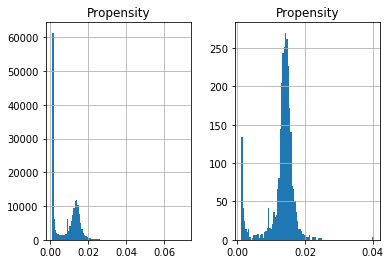

In [59]:
fig, axes = plt.subplots(1, 2)
df.hist('Propensity', bins=100, ax=axes[0])
matched_df.hist( 'Propensity', bins=100, ax=axes[1])

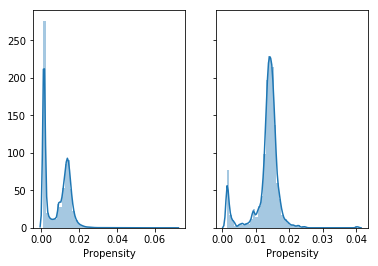

In [60]:
import seaborn as sns
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.distplot(df['Propensity'], ax=ax1)
sns.distplot(matched_df['Propensity'], ax=ax2)

In [236]:
#Finding mean and standard error AFTER matching when Throwaway = 1 
Match_Throwaway = matched_df[matched_df['Throwaway']==1]
Cov_match = Match_Throwaway[All_Features]
means = Cov_match.mean()
stds = Cov_match.std()
print(means[Covariates], stds[Covariates])

tenure                                      0.088548
Male_Norms                                  0.000852
CPS_Child_Abuse                             0.001207
Parenting_Pregnany_Hardships_Experiences    0.000691
Work_Parenting_Schedule                     0.000510
Parenting_Nature                            0.000430
Cost_Financial_Planning                     0.000604
Diagnosing_Disorders                        0.000283
Challenging_Behavior                        0.000615
adj                                         0.032252
Child_Autonomy_Str_Danger                   0.000213
Religious_Social_Beleifs                    0.000598
number                                      0.004514
Naked_Privacy                               0.000132
Managing_Grief_Unexpected_Pregnancy         0.000735
verb                                        0.122031
Parenting_Groups_Religious                  0.000360
Circumcision                                0.000186
dtype: float64 tenure                         

In [71]:
df_throw = df[df['Throwaway']==1]
df_match = df[All_Features]
means = df_match.mean()

In [235]:
print(means[Covariates])

tenure                                      0.085629
Male_Norms                                  0.000893
CPS_Child_Abuse                             0.000796
Parenting_Pregnany_Hardships_Experiences    0.000628
Work_Parenting_Schedule                     0.000449
Parenting_Nature                            0.000430
Cost_Financial_Planning                     0.000669
Diagnosing_Disorders                        0.000299
Challenging_Behavior                        0.000791
adj                                         0.034113
Child_Autonomy_Str_Danger                   0.000243
Religious_Social_Beleifs                    0.000736
number                                      0.005198
Naked_Privacy                               0.000093
Managing_Grief_Unexpected_Pregnancy         0.000655
verb                                        0.121802
Parenting_Groups_Religious                  0.000228
Circumcision                                0.000155
dtype: float64


In [73]:
#Finding mean and standard error AFTER matching when Throwaway = 0
Match_Throwaway = matched_df[matched_df['Throwaway']==0]
Cov_match = Match_Throwaway[All_Features]
means = Cov_match.mean()
stds = Cov_match.std()
print(means, stds)

score                                       0.074417
tenure                                      0.085629
WC                                          0.734978
adverb                                      0.041991
relativ                                     0.088955
focuspresent                                0.081535
time                                        0.037284
function                                    0.393673
you                                         0.019247
social                                      0.100685
ppron                                       0.087197
pronoun                                     0.132608
verb                                        0.121802
i                                           0.033825
space                                       0.039849
prep                                        0.086641
affiliation                                 0.017606
we                                          0.006432
drives                                      0.

In [39]:
matched_df.head(100)

,After_First_Child,Allergy_Sick_Runny_Nose,BabyProof_Accidents,Baby_Gear,Bathtime_Sleep_Routine,Birth,Bully,CPS_Child_Abuse,Challenging_Behavior,Child_Activity,Child_Autonomy_Str_Danger,Child_Food,Child_Support_CPS,Children_Socializing,Circumcision,College,Congrats,Cost_Financial_Planning,Dad_Support,Diagnosing_Disorders,Diapers,Dogs,Doors_Child Accidents,Edu_Phil,Family_Car,Father_Role,Grandparents,Hair_Care,Joke,Language_Reading,Male_Norms,Managing_Grief_Unexpected_Pregnancy,Media,Moderator,Music,Naked_Privacy,Nursing,Parent_Gear,Parenting_Groups_Religious,Parenting_Jokes,Parenting_Nature,Parenting_Pregnany_Hardships_Experiences,Picky_Eaters,Potty_Training,Psych_Stress,Puppy,Religious_Social_Beleifs,Santa,School,Skin_Care_Cloth,Sleep_Training,Smoke_Drugs_Alcohol,Swimming,Tantrum_Mngmnt_Discipline,Teen_Changes,Thanks_Support,Throwaway,Toys_Playing,Vaccines,WC,Work_Parenting_Schedule,achieve,adj,adverb,affect,affiliation,anger,anx,article,assent,auxverb,bio,body,cause,certain,cogproc,compare,conj,death,differ,discrep,drives,family,feel,female,filler,focusfuture,focuspast,focuspresent,friend,function,health,hear,home,i,informal,ingest,insight,interrog,ipron,leisure,male,money,motion,negate,negemo,netspeak,nonflu,number,percept,posemo,power,ppron,prep,pronoun,quant,relativ,relig,reward,risk,sad,score,see,sexual,shehe,social,space,swear,tentat,they,time,verb,we,work,you,tenure,Propensity
author,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Childthrowaway12,0.000000,0.002157,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000496,0.001155,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,9.037275e-04,0.000108,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000807,0.000000e+00,0.000000e+00,0.000000,0.000153,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000143,0.000000e+00,0.000000e+00,0.000163,0.001294,0.000563,0.000000,0.000000,0.000000,0.000000,0.000000,0.000434,0.000000e+00,1,0.000000,0.000000,0.802869,0.000123,0.015580,0.025966,0.067512,0.037391,0.009348,0.004155,0.000000,0.048816,0.006232,0.063357,0.010386,0.005193,0.018696,0.011425,0.101787,0.014541,0.073743,0.009348,0.031159,0.013502,0.043623,0.005193,0.005193,0.049855,0.000000,0.013502,0.041546,0.079975,0.000000,0.465311,0.002077,0.007270,0.005193,0.027005,0.009348,0.003116,0.017657,0.018696,0.050893,0.009348,0.007270,0.002077,0.015580,0.006232,0.010386,0.001039,0.000000,0.005193,0.031159,0.022850,0.004155,0.096594,0.085169,0.147487,0.007270,0.102825,0.000000,0.018696,0.004155,0.002077,0.041546,0.017657,0.000000,0.051932,0.108019,0.037391,0.002077,0.027005,0.008309,0.052971,0.132946,0.004155,0.012464,0.005193,0.000000,0.014731
mockyouthrowaway,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.184172,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1,0.000000,0.000000,0.737171,0.000000,0.000000,0.000000,0.245724,0.245724,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.245724,0.000000,0.000000,0.000000,0.000000,0.245724,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.245724,0.245724,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0

# Throwaway Comments

In [223]:
Throwaway = matched_df[matched_df['Throwaway']==1]
Pseudony  = matched_df[matched_df['Throwaway']==0]

In [224]:
from statsmodels.sandbox.stats.multicomp import multipletests

Delta is -0.008539449611122227
Ttest_indResult(statistic=-1.7957059255550669, pvalue=0.072644793586694081)


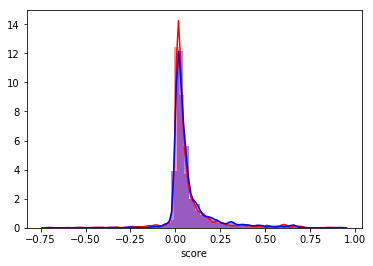

In [226]:
Variable = 'score'
Delta_Score = Throwaway[Variable].mean()- Pseudony[Variable].mean()
print('Delta is',Delta_Score)

print(ttest_ind(Throwaway[Variable],Pseudony[Variable]))

import seaborn as sns
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.distplot(Throwaway[Variable],kde='True', hist=True, label="Throwaway", color='red')
sns.distplot(Pseudony[Variable],kde='True', hist=True, label="Pseudonymous", color='blue')

Delta is 0.007724307812284142
Ttest_indResult(statistic=4.5284598404754917, pvalue=6.1798446729534245e-06)


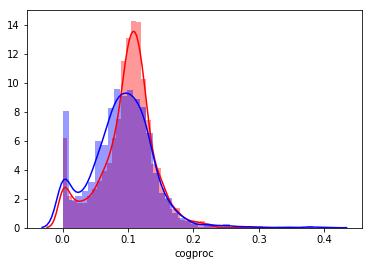

In [228]:
Variable = 'cogproc'
Delta_Score = Throwaway[Variable].mean()- Pseudony[Variable].mean()
print('Delta is',Delta_Score)

print(ttest_ind(Throwaway[Variable],Pseudony[Variable]))

import seaborn as sns
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.distplot(Throwaway[Variable],kde='True', hist=True, label="Throwaway", color='red')
sns.distplot(Pseudony[Variable],kde='True', hist=True, label="Pseudonymous", color='blue')

Delta is 0.001411000063207114
Ttest_indResult(statistic=2.0801879671319328, pvalue=0.037595423678202421)


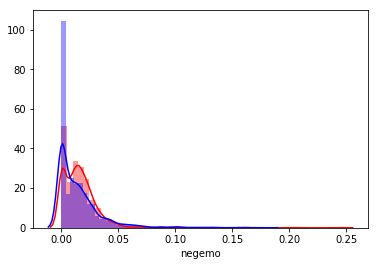

In [230]:
Variable = 'negemo'
Delta_Score = Throwaway[Variable].mean()- Pseudony[Variable].mean()
print('Delta is',Delta_Score)

print(ttest_ind(Throwaway[Variable],Pseudony[Variable]))

import seaborn as sns
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.distplot(Throwaway[Variable],kde='True', hist=True, label="Throwaway", color='red')
sns.distplot(Pseudony[Variable],kde='True', hist=True, label="Pseudonymous", color='blue')

Delta is 7.531035794083873e-05
Ttest_indResult(statistic=0.012151552878577065, pvalue=0.99030553343234018)


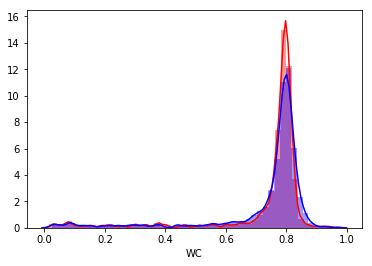

In [227]:
Variable = 'WC'
Delta_Score = Throwaway[Variable].mean()- Pseudony[Variable].mean()
print('Delta is',Delta_Score)

print(ttest_ind(Throwaway[Variable],Pseudony[Variable]))

import seaborn as sns
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.distplot(Throwaway[Variable],kde='True', hist=True, label="Throwaway", color='red')
sns.distplot(Pseudony[Variable],kde='True', hist=True, label="Pseudonymous", color='blue')

# Responses

In [78]:
Parents_Sent_LDA_Comp = pd.read_pickle('Parenting_Complete_Sentiment_LDA.pkl')

In [79]:
Parents = Parents_Sent_LDA_Comp.copy()

In [80]:
Parents.head()

,Throwaway,author,created_utc,score,WC,adverb,relativ,focuspresent,time,function,you,social,ppron,pronoun,verb,i,space,prep,affiliation,we,drives,home,article,bio,body,motion,number,percept,adj,see,money,death,power,work,ipron,informal,assent,interrog,auxverb,cause,cogproc,tentat,compare,quant,affect,posemo,leisure,conj,differ,negate,insight,they,focusfuture,reward,focuspast,negemo,health,achieve,feel,family,female,sad,risk,shehe,male,discrep,certain,hear,nonflu,netspeak,anx,ingest,friend,filler,anger,sexual,swear,relig,name,link_id,parent_id,Picky_Eaters,Sleep_Training,Nursing,Dad_Support,Parenting_Jokes,Smoke_Drugs_Alcohol,College,Grandparents,Naked_Privacy,Allergy_Sick_Runny_Nose,Child_Food,Parenting_Groups_Religious,Father_Role,Toys_Playing,Diapers,After_First_Child,Child_Activity,Baby_Gear,Psych_Stress,Parent_Gear,Child_Autonomy_Str_Danger,Circumcision,Hair_Care,Vaccines,Teen_Changes,BabyProof_Accidents,Swimming,Moderator,School,Male_Norms,Birth,Joke,Dogs,Diagnosing_Disorders,Cost_Financial_Planning,Children_Socializing,Santa,Work_Parenting_Schedule,Religious_Social_Beleifs,CPS_Child_Abuse,Bathtime_Sleep_Routine,Media,Tantrum_Mngmnt_Discipline,Puppy,Parenting_Pregnany_Hardships_Experiences,Potty_Training,Language_Reading,Music,Edu_Phil,Congrats,Challenging_Behavior,Managing_Grief_Unexpected_Pregnancy,Doors_Child Accidents,Family_Car,Bully,Thanks_Support,Parenting_Nature,Skin_Care_Cloth,Child_Support_CPS
0,0,None,2008-03-31 12:44:58,1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,t1_c03l6im,t3_6e0oe,t3_6e0oe,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.671383,0.000000
1,0,kickstand,2008-04-09 15:16:05,1,4.0,1.0,1.0,2.0,1.0,3.0,1.0,2.0,2.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,t1_c03o5z1,t3_6d8mw,t3_6d8mw,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286
2,0,kickstand,2008-04-09 15:17:46,1,30.0,0.0,3.0,0.0,0.0,7.0,0.0,1.0,1.0,2.0,0.0,0.0,2.0,3.0,1.0,1.0,2.0,1.0,2.0,2.0,2.0,1.0,1.0,3.0,2.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,t1_c03o5zp,t3_6d8mh,t3_6d8mh,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.614963,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00

In [191]:
list_of_throwaways = matched_df[matched_df['Throwaway']==1].index.values
list_of_comments_throwaway_total = get_list_of_names(Parents, list_of_throwaways)
All_Throwaway_replies = get_replies(Parents, list_of_comments_throwaway_total)
print(len(All_Throwaway_replies))
print(len(list_of_throwaways))

In [232]:
len(All_Throwaway_replies)

3993

In [231]:
len(All_Throwaway_replies.author.unique())

2249

In [85]:
All_Throwaway_replies.to_pickle('All_Throwaway_Replies.pkl')

In [86]:
All_Throwaway_replies = pd.read_pickle('All_Throwaway_Replies.pkl')

In [202]:
#Getting the possibility of receving a reply 
#by matching the parent_id from the link of Throwaway_replies to the comment_name
#I did this by comparing the list of parent_id with comment_name for each of the throwaway
#and the pseud matches...
list_of_parent = All_Throwaway_replies.parent_id.unique()

Throwaway_comments = Mizo_All[Mizo_All['Throwaway']==1]

Throwaway_comments['got_reply']= Throwaway_comments.name.isin(list_of_parent)

Throwaway_comments['got_reply'] = Throwaway_comments['got_reply'].astype(int)

Throwawy_possibility_comment = pd.pivot_table(Throwaway_comments, index= 'author', aggfunc= 'mean')

Throwawy_possibility_comment['got_reply']

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


author
-throwaway--acc-        0.000000
-throwaway9             1.000000
0throwawayyyyys         0.000000
10-10throwaway          0.000000
1029throwaway384756     0.000000
120kthrownaway          0.000000
1234throwawayyyy        0.000000
129800throwaway         0.000000
14yo_throwaway222       0.342342
15_27_throwaway         0.000000
1bbdsthrowaway          0.000000
2012throwawayy          1.000000
234123423throwaway      0.000000
2468imgonnathrowaway    0.421053
2thrwawyneedhelp        0.285714
2thrwawyneedhelp2       0.666667
37weeks-throwaway       1.000000
48484throwaway          0.000000
857throwaway            1.000000
87throwaway97           0.000000
8monthsthrowaway        0.000000
8thrw4y                 0.000000
9000throw               0.000000
AMAthrowaway7           0.500000
ANOTHER__throwaway_4    0.000000
ATS_throwaway           0.000000
AltruisticBicycle       0.000000
Anotherparentthrowaw    0.000000
Apparentthrow           0.000000
Askmenthrowaway321      0.000000
   

In [88]:
list_of_pseud = matched_df[matched_df['Throwaway']==0].index.values
list_of_comments_pseud_total = get_list_of_names(Parents, list_of_pseud)
All_Pseud_replies = get_replies(Parents, list_of_comments_pseud_total)
print(len(All_Pseud_replies))
print(len(list_of_pseud))

917
1459


In [233]:
len(All_Pseud_replies.author.unique())

679

In [90]:
All_Pseud_replies.to_pickle('All_Pseud_Replies.pkl')

In [92]:
All_Pseud_replies.head()

,Throwaway,author,created_utc,score,WC,adverb,relativ,focuspresent,time,function,you,social,ppron,pronoun,verb,i,space,prep,affiliation,we,drives,home,article,bio,body,motion,number,percept,adj,see,money,death,power,work,ipron,informal,assent,interrog,auxverb,cause,cogproc,tentat,compare,quant,affect,posemo,leisure,conj,differ,negate,insight,they,focusfuture,reward,focuspast,negemo,health,achieve,feel,family,female,sad,risk,shehe,male,discrep,certain,hear,nonflu,netspeak,anx,ingest,friend,filler,anger,sexual,swear,relig,name,link_id,parent_id,Picky_Eaters,Sleep_Training,Nursing,Dad_Support,Parenting_Jokes,Smoke_Drugs_Alcohol,College,Grandparents,Naked_Privacy,Allergy_Sick_Runny_Nose,Child_Food,Parenting_Groups_Religious,Father_Role,Toys_Playing,Diapers,After_First_Child,Child_Activity,Baby_Gear,Psych_Stress,Parent_Gear,Child_Autonomy_Str_Danger,Circumcision,Hair_Care,Vaccines,Teen_Changes,BabyProof_Accidents,Swimming,Moderator,School,Male_Norms,Birth,Joke,Dogs,Diagnosing_Disorders,Cost_Financial_Planning,Children_Socializing,Santa,Work_Parenting_Schedule,Religious_Social_Beleifs,CPS_Child_Abuse,Bathtime_Sleep_Routine,Media,Tantrum_Mngmnt_Discipline,Puppy,Parenting_Pregnany_Hardships_Experiences,Potty_Training,Language_Reading,Music,Edu_Phil,Congrats,Challenging_Behavior,Managing_Grief_Unexpected_Pregnancy,Doors_Child Accidents,Family_Car,Bully,Thanks_Support,Parenting_Nature,Skin_Care_Cloth,Child_Support_CPS
999988,0,sam182666,2014-11-04 11:26:27,2,38.0,0.0,5.0,4.0,2.0,17.0,0.0,3.0,3.0,3.0,6.0,0.0,3.0,6.0,2.0,2.0,6.0,0.0,4.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,3.0,1.0,3.0,3.0,2.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,t1_clsk2wn,t3_2l8wm1,t1_clsjpdg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.950695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
1107256,0,ScarletAngel,2015-02-11 00:26:06,2,26.0,0.0,2.0,1.0,0.0,11.0,3.0,6.0,3.0,5.0,0.0,0.0,2.0,4.0,1.0,0.0,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,t1_cohly9i,t3_2vgvkq,t1_cohjtck,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.890459,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
1107273,0,LadyGrizabella,2015-02-11 00:57:03,2,91.0,7.0,17.0,7.0,9.0,51.0,0.0,7.0,10.0,16.0,13.0,5.0,6.0,10.0,1.0,1.0,3.0,0.0,7.0,1.0,0.0,2.0,0.0,6.0,0.0,5.0,0.0,0.0,2.0,0.0,6.0,2.0,0.0,2.0,7.0,0.0,5.0,1.0,0.0,0.0,3.0,1.0,0.0,4.0,2.0,3.0,1.0,0.0,0.0,0.0,9.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,4.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,t1_cohmzzi,t3_2vgvkq,t1_cohjvhn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.212477,0.0,0.0,0.000000,0.0,0.0
692896,0,LadyGrizabella,2014-01-11 01:38:14,2,234.0,15.0,36.0,18.0,20.0,129.0,0.0,12.0,31.0,48.0,30.0,29.0,15.0,29.0,1.0,1.0,16.0,0.0,11.0,5.0,1.0,1.0,6.0,8.0,10.0,3.0,0.0,0.0,9.0,4.0,17.0,1.0,0.0,1.0,13.0,1.0,41.0,17.0,7.0,7.0,4.0,4.0,0.0,15.0,14.0,4.0,8.0,0.0,2.0,5.0,11.0,0.0,4.0,3.0,4.0,3.0,0.0,0.0,0.0,1.0,4.0,10.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,t1_cemm71q,t3_1uwrwo,t1_cemfwxx,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.020778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.9

In [203]:
#Getting the possibility of receving a reply 
#by matching the parent_id from the link of Throwaway_replies to the comment_name
#I did this by comparing the list of parent_id with comment_name for each of the throwaway
#and the pseud matches...
list_of_parent = All_Pseud_replies.parent_id.unique()

Pseud_comments = Mizo_All[Mizo_All['Throwaway']==0]

Pseud_comments['got_reply']= Pseud_comments.name.isin(list_of_parent)

Pseud_comments['got_reply'] = Pseud_comments['got_reply'].astype(int)

Pseud_comments_comment = pd.pivot_table(Pseud_comments, index= 'author', aggfunc= 'mean')

Pseud_comments_comment['got_reply']

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


author
----------FTFY        0.0
------me              0.0
-----iMartijn-----    0.0
-----username-----    0.0
----_____----         0.0
---Bokonon---         0.0
---DAD---             0.0
---annon---           0.0
---sniff---           0.0
--0o0o0--             0.0
--ACAB--              0.0
--Adventurer--        0.0
--BMO--               0.0
--BotDetector--       0.0
--Edog--              0.0
--Greg--              0.0
--Heretic--           0.0
--MichaelScott---     0.0
--PaintedShoes__      0.0
--Petrichor--         0.0
--Ping--              0.0
--Quartz--            0.0
--VuDu--              0.0
--Word                0.0
--amber--             0.0
--cunt                0.0
--danneskjold--       0.0
--e                   0.0
--ev---bbbb--         0.0
--geode               0.0
                     ... 
zyk0s                 0.0
zyklon65              0.0
zylithi               0.0
zymologist            0.0
zynna-lynn            0.0
zynthalay             0.0
zynthesis1981         0.0
zyphe

In [207]:
Pseud_comments_comment[Pseud_comments_comment['got_reply']>0.3]

,After_First_Child,Allergy_Sick_Runny_Nose,BabyProof_Accidents,Baby_Gear,Bathtime_Sleep_Routine,Birth,Bully,CPS_Child_Abuse,Challenging_Behavior,Child_Activity,Child_Autonomy_Str_Danger,Child_Food,Child_Support_CPS,Children_Socializing,Circumcision,College,Congrats,Cost_Financial_Planning,Dad_Support,Diagnosing_Disorders,Diapers,Dogs,Doors_Child Accidents,Edu_Phil,Family_Car,Father_Role,Grandparents,Hair_Care,Joke,Language_Reading,Male_Norms,Managing_Grief_Unexpected_Pregnancy,Media,Moderator,Music,Naked_Privacy,Nursing,Parent_Gear,Parenting_Groups_Religious,Parenting_Jokes,Parenting_Nature,Parenting_Pregnany_Hardships_Experiences,Picky_Eaters,Potty_Training,Psych_Stress,Puppy,Religious_Social_Beleifs,Santa,School,Skin_Care_Cloth,Sleep_Training,Smoke_Drugs_Alcohol,Swimming,Tantrum_Mngmnt_Discipline,Teen_Changes,Thanks_Support,Throwaway,Toys_Playing,Vaccines,WC,Work_Parenting_Schedule,achieve,adj,adverb,affect,affiliation,anger,anx,article,assent,auxverb,bio,body,cause,certain,cogproc,compare,conj,death,differ,discrep,drives,family,feel,female,filler,focusfuture,focuspast,focuspresent,friend,function,got_reply,health,hear,home,i,informal,ingest,insight,interrog,ipron,leisure,male,money,motion,negate,negemo,netspeak,nonflu,number,percept,posemo,power,ppron,prep,pronoun,quant,relativ,relig,reward,risk,sad,score,see,sexual,shehe,social,space,swear,tentat,they,time,verb,we,work,you
author,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1-800-XXX-XXXX,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.968187,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,67.000000,0.000000,0.000000,3.000000,0.000000,6.000000,1.000000,0.000000,0.000000,3.000000,0.000000,8.000000,0.000000,0.000000,1.000000,0.000000,8.000000,0.000000,3.000000,0.000000,1.000000,1.000000,7.000000,0.000000,0.000000,0.000000,0.0000,2.000000,1.000000,9.000000,0.000000,33.000000,1.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,3.000000,1.000000,5.000000,0.000000,3.000000,2.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,5.000000,3.000000,5.000000,9.000000,10.000000,0.000000,2.000000,0.000000,2.000000,1.000000,0.000000,1.000000,0.000000,0.000000,3.000000,11.000000,2.000000,0.000000,2.000000,0.000000,0.000000,13.000000,0.000000,3.000000,0.000000
1010101110,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.753229,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000

In [218]:
pvals_before = [0.0,0.0,0.00039779285430183566,4.9363725681122296e-06,0.0066407761573514107,0.00050304692996745227,\
          0.0008084193408922696,4.6601984881958272e-05,0.0015702961485412478,4.7693693822498538e-05,\
          2.0832552739164995e-05,0.00081527430578021479,6.8561365495997923e-06,5.1203084047720109e-05,\
          3.2990030333040002e-05,6.8035832321733408e-05,3.9685357308638335e-05,0.00032333841857235023,\
          0.0023002717025265278,0.00074133921664281831,2.1017722728830134e-07,0.0071276955886776837,\
            8.9429927037627496e-07,0.0011668952659111326,0.00050304692996745227,3.6433841228847915e-07,\
               1.8561342581127121e-10,9.1075825993407918e-08]

In [219]:
adjp_vals = multipletests(pvals=pvalues, alpha=0.05, method='b', is_sorted=False, returnsorted=False)

In [220]:
adjp_vals

(array([ True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False, False,  True,  True, False,  True,  True, False,
         True,  True,  True,  True], dtype=bool),
 array([  0.00000000e+00,   0.00000000e+00,   1.23315785e-02,
          1.53027550e-04,   2.05864061e-01,   1.55944548e-02,
          2.50609996e-02,   1.44466153e-03,   4.86791806e-02,
          1.47850451e-03,   6.45809135e-04,   4.86791806e-02,
          2.52735035e-02,   2.12540233e-04,   1.58729561e-03,
          1.02269094e-03,   2.10911080e-03,   1.23024608e-03,
          1.00234910e-02,   4.49097671e-01,   7.13084228e-02,
          2.29815157e-02,   6.51549405e-06,   2.20958563e-01,
          2.77232774e-05,   3.61737532e-02,   9.98199470e-02,
          1.55944548e-02,   1.12944908e-05,   5.75401620e-09,
          2.82335061e-06]),
 0.00165325426664098,
 0.0016129032258064516)

Delta is 0.17920982878472988
Ttest_indResult(statistic=162.80308959632052, pvalue=0.0)


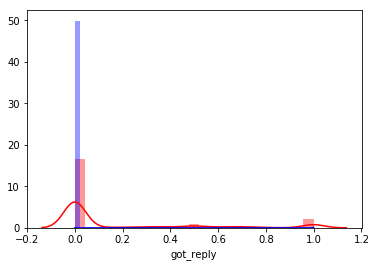

In [211]:
Delta_Replies = Throwawy_possibility_comment['got_reply'].mean()- Pseud_comments_comment['got_reply'].mean()
print('Delta is',Delta_Replies)

print(ttest_ind(Throwawy_possibility_comment['got_reply'],Pseud_comments_comment['got_reply']))

import seaborn as sns
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.distplot(Throwawy_possibility_comment['got_reply'],kde='True', hist=True, label="Throwaway", color='red')
sns.distplot(Pseud_comments_comment['got_reply'],kde='True', hist=True, label="Pseudonymous", color='blue')

Delta is 3.0681896699813542
Ttest_indResult(statistic=1790.0910583272564, pvalue=0.0)


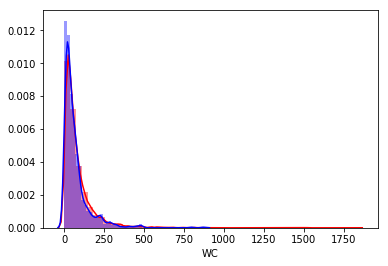

In [148]:
Delta_Replies = All_Throwaway_replies.count()- All_Pseud_replies.count()
print('Delta is',Delta_Score)

print(ttest_ind(All_Throwaway_replies.count(),All_Pseud_replies.count()))

import seaborn as sns
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.distplot(All_Throwaway_replies['WC'],kde='True', hist=True, label="Throwaway", color='red')
sns.distplot(All_Pseud_replies['WC'],kde='True', hist=True, label="Pseudonymous", color='blue')

Delta is 12.903044613788424
Ttest_indResult(statistic=3.5439883123109146, pvalue=0.00039779285430183566)


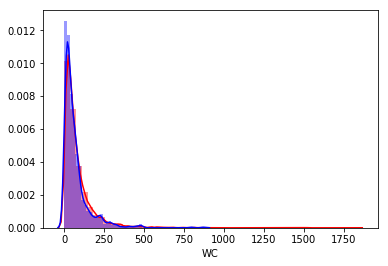

In [93]:
Delta_Score = All_Throwaway_replies['WC'].mean()- All_Pseud_replies['WC'].mean()
print('Delta is',Delta_Score)

print(ttest_ind(All_Throwaway_replies['WC'],All_Pseud_replies['WC']))

import seaborn as sns
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.distplot(All_Throwaway_replies['WC'],kde='True', hist=True, label="Throwaway", color='red')
sns.distplot(All_Pseud_replies['WC'],kde='True', hist=True, label="Pseudonymous", color='blue')

Delta is 2.1141733584481677
Ttest_indResult(statistic=4.5725650598266405, pvalue=4.9363725681122296e-06)


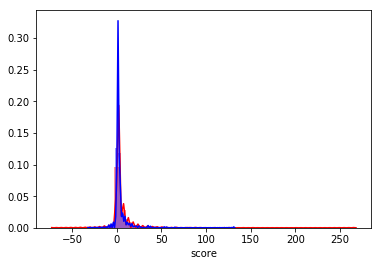

In [94]:
Delta_Score = All_Throwaway_replies['score'].mean()- All_Pseud_replies['score'].mean()
print('Delta is',Delta_Score)

print(ttest_ind(All_Throwaway_replies['score'],All_Pseud_replies['score']))

import seaborn as sns
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.distplot(All_Throwaway_replies['score'],kde='True', hist=True, label="Throwaway", color='red')
sns.distplot(All_Pseud_replies['score'],kde='True', hist=True, label="Pseudonymous", color='blue')

Delta is 0.4134334321704205
Ttest_indResult(statistic=2.7154984230342305, pvalue=0.0066407761573514107)


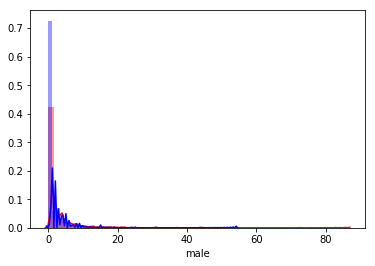

In [96]:
Delta_Score = All_Throwaway_replies['male'].mean()- All_Pseud_replies['male'].mean()
print('Delta is',Delta_Score)

print(ttest_ind(All_Throwaway_replies['male'],All_Pseud_replies['male']))

import seaborn as sns
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.distplot(All_Throwaway_replies['male'],kde='True', hist=True, label="Throwaway", color='red')
sns.distplot(All_Pseud_replies['male'],kde='True', hist=True, label="Pseudonymous", color='blue')

Delta is 0.07758288018208526
Ttest_indResult(statistic=2.4750192832576814, pvalue=0.013356425858916854)


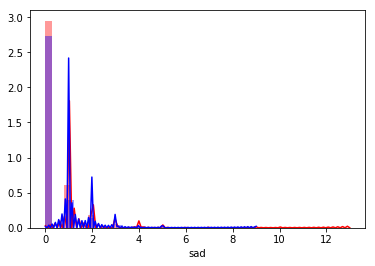

In [97]:
Variable = 'sad'
Delta_Score = All_Throwaway_replies[Variable].mean()- All_Pseud_replies[Variable].mean()
print('Delta is',Delta_Score)

print(ttest_ind(All_Throwaway_replies[Variable],All_Pseud_replies[Variable]))

import seaborn as sns
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.distplot(All_Throwaway_replies[Variable],kde='True', hist=True, label="Throwaway", color='red')
sns.distplot(All_Pseud_replies[Variable],kde='True', hist=True, label="Pseudonymous", color='blue')

Delta is 0.20060077873465043
Ttest_indResult(statistic=1.6690215434108862, pvalue=0.095176889310554805)


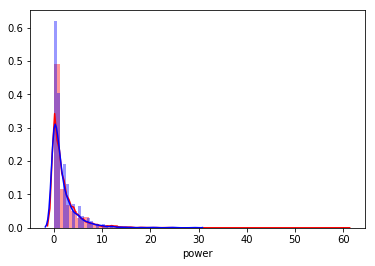

In [98]:
Variable = 'power'
Delta_Score = All_Throwaway_replies[Variable].mean()- All_Pseud_replies[Variable].mean()
print('Delta is',Delta_Score)

print(ttest_ind(All_Throwaway_replies[Variable],All_Pseud_replies[Variable]))

import seaborn as sns
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.distplot(All_Throwaway_replies[Variable],kde='True', hist=True, label="Throwaway", color='red')
sns.distplot(All_Pseud_replies[Variable],kde='True', hist=True, label="Pseudonymous", color='blue')

Delta is 0.16640325586133414
Ttest_indResult(statistic=3.481452414872483, pvalue=0.00050304692996745227)


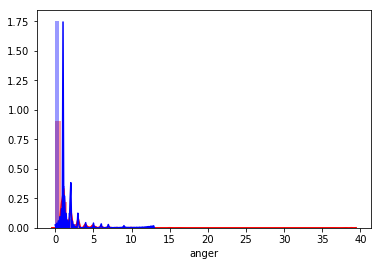

In [99]:
Variable = 'anger' 
Delta_Score = All_Throwaway_replies[Variable].mean()- All_Pseud_replies[Variable].mean()
print('Delta is',Delta_Score)

print(ttest_ind(All_Throwaway_replies[Variable],All_Pseud_replies[Variable]))

import seaborn as sns
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.distplot(All_Throwaway_replies[Variable],kde='True', hist=True, label="Throwaway", color='red')
sns.distplot(All_Pseud_replies[Variable],kde='True', hist=True, label="Pseudonymous", color='blue')

Delta is 0.4473155175319077
Ttest_indResult(statistic=3.351982545925912, pvalue=0.0008084193408922696)


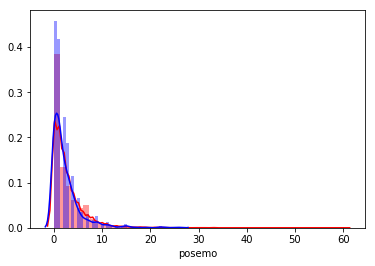

In [100]:
Variable = 'posemo' 
Delta_Score = All_Throwaway_replies[Variable].mean()- All_Pseud_replies[Variable].mean()
print('Delta is',Delta_Score)

print(ttest_ind(All_Throwaway_replies[Variable],All_Pseud_replies[Variable]))

import seaborn as sns
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.distplot(All_Throwaway_replies[Variable],kde='True', hist=True, label="Throwaway", color='red')
sns.distplot(All_Pseud_replies[Variable],kde='True', hist=True, label="Pseudonymous", color='blue')

Delta is 0.492531231727497
Ttest_indResult(statistic=4.0756955802822539, pvalue=4.6601984881958272e-05)


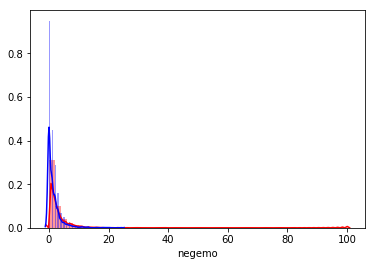

In [101]:
Variable = 'negemo' 
Delta_Score = All_Throwaway_replies[Variable].mean()- All_Pseud_replies[Variable].mean()
print('Delta is',Delta_Score)

print(ttest_ind(All_Throwaway_replies[Variable],All_Pseud_replies[Variable]))

import seaborn as sns
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.distplot(All_Throwaway_replies[Variable],kde='True', hist=True, label="Throwaway", color='red')
sns.distplot(All_Pseud_replies[Variable],kde='True', hist=True, label="Pseudonymous", color='blue')

Delta is 0.009048786666063874
Ttest_indResult(statistic=0.39073510941858625, pvalue=0.6960095656475073)


/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


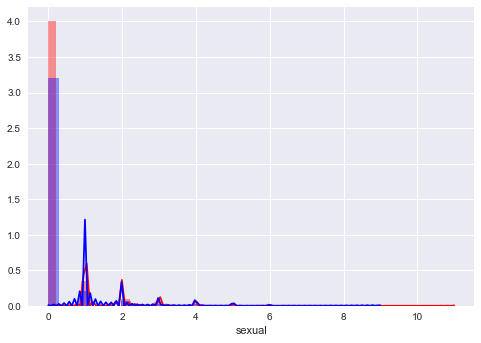

In [59]:
Variable = 'sexual' 
Delta_Score = All_Throwaway_replies[Variable].mean()- All_Pseud_replies[Variable].mean()
print('Delta is',Delta_Score)

print(ttest_ind(All_Throwaway_replies[Variable],All_Pseud_replies[Variable]))

import seaborn as sns
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.distplot(All_Throwaway_replies[Variable],kde='True', hist=True, label="Throwaway", color='red')
sns.distplot(All_Pseud_replies[Variable],kde='True', hist=True, label="Pseudonymous", color='blue')

Delta is 0.03501219828265434
Ttest_indResult(statistic=0.34614697664205379, pvalue=0.72924709800594001)


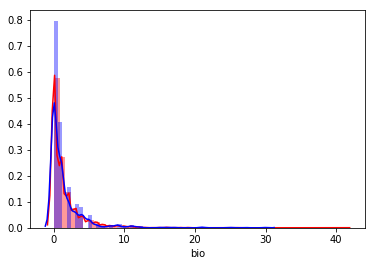

In [102]:
Variable = 'bio' 
Delta_Score = All_Throwaway_replies[Variable].mean()- All_Pseud_replies[Variable].mean()
print('Delta is',Delta_Score)

print(ttest_ind(All_Throwaway_replies[Variable],All_Pseud_replies[Variable]))

import seaborn as sns
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.distplot(All_Throwaway_replies[Variable],kde='True', hist=True, label="Throwaway", color='red')
sns.distplot(All_Pseud_replies[Variable],kde='True', hist=True, label="Pseudonymous", color='blue')

Delta is -0.012344121296237881
Ttest_indResult(statistic=-1.0238350984505251, pvalue=0.30596362861191062)


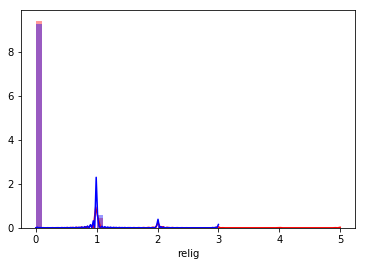

In [103]:
Variable = 'relig' 
Delta_Score = All_Throwaway_replies[Variable].mean()- All_Pseud_replies[Variable].mean()
print('Delta is',Delta_Score)

print(ttest_ind(All_Throwaway_replies[Variable],All_Pseud_replies[Variable]))

import seaborn as sns
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.distplot(All_Throwaway_replies[Variable],kde='True', hist=True, label="Throwaway", color='red')
sns.distplot(All_Pseud_replies[Variable],kde='True', hist=True, label="Pseudonymous", color='blue')

Delta is 0.07206504512668166
Ttest_indResult(statistic=1.569199659416664, pvalue=0.11666588722099241)


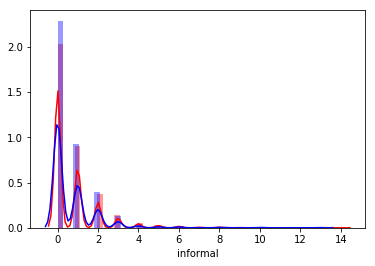

In [104]:
Variable = 'informal' 
Delta_Score = All_Throwaway_replies[Variable].mean()- All_Pseud_replies[Variable].mean()
print('Delta is',Delta_Score)

print(ttest_ind(All_Throwaway_replies[Variable],All_Pseud_replies[Variable]))

import seaborn as sns
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.distplot(All_Throwaway_replies[Variable],kde='True', hist=True, label="Throwaway", color='red')
sns.distplot(All_Pseud_replies[Variable],kde='True', hist=True, label="Pseudonymous", color='blue')

Delta is 0.03262415879916353
Ttest_indResult(statistic=1.650200817849248, pvalue=0.098965856249370099)


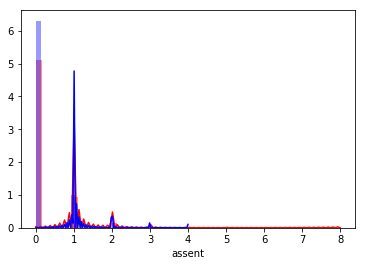

In [105]:
Variable = 'assent' 
Delta_Score = All_Throwaway_replies[Variable].mean()- All_Pseud_replies[Variable].mean()
print('Delta is',Delta_Score)

print(ttest_ind(All_Throwaway_replies[Variable],All_Pseud_replies[Variable]))

import seaborn as sns
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.distplot(All_Throwaway_replies[Variable],kde='True', hist=True, label="Throwaway", color='red')
sns.distplot(All_Pseud_replies[Variable],kde='True', hist=True, label="Pseudonymous", color='blue')

Delta is 0.2396759760333036
Ttest_indResult(statistic=3.1631399891425729, pvalue=0.0015702961485412478)


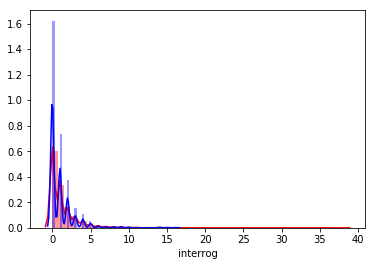

In [106]:
Variable = 'interrog' 
Delta_Score = All_Throwaway_replies[Variable].mean()- All_Pseud_replies[Variable].mean()
print('Delta is',Delta_Score)

print(ttest_ind(All_Throwaway_replies[Variable],All_Pseud_replies[Variable]))

import seaborn as sns
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.distplot(All_Throwaway_replies[Variable],kde='True', hist=True, label="Throwaway", color='red')
sns.distplot(All_Pseud_replies[Variable],kde='True', hist=True, label="Pseudonymous", color='blue')

Delta is 0.9581194571416014
Ttest_indResult(statistic=4.0702861686364171, pvalue=4.7693693822498538e-05)


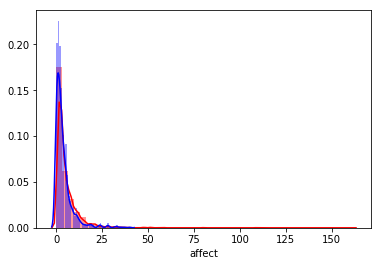

In [107]:
Variable = 'affect'
Delta_Score = All_Throwaway_replies[Variable].mean()- All_Pseud_replies[Variable].mean()
print('Delta is',Delta_Score)

print(ttest_ind(All_Throwaway_replies[Variable],All_Pseud_replies[Variable]))

import seaborn as sns
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.distplot(All_Throwaway_replies[Variable],kde='True', hist=True, label="Throwaway", color='red')
sns.distplot(All_Pseud_replies[Variable],kde='True', hist=True, label="Pseudonymous", color='blue')

Delta is -0.03756109724187451
Ttest_indResult(statistic=-0.94806157198387331, pvalue=0.34314478633770007)


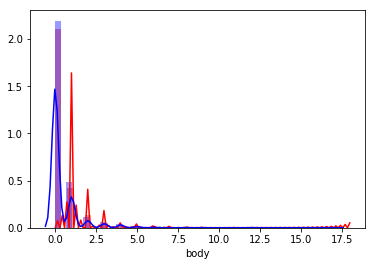

In [108]:
Variable = 'body'
Delta_Score = All_Throwaway_replies[Variable].mean()- All_Pseud_replies[Variable].mean()
print('Delta is',Delta_Score)

print(ttest_ind(All_Throwaway_replies[Variable],All_Pseud_replies[Variable]))

import seaborn as sns
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.distplot(All_Throwaway_replies[Variable],kde='True', hist=True, label="Throwaway", color='red')
sns.distplot(All_Pseud_replies[Variable],kde='True', hist=True, label="Pseudonymous", color='blue')

Delta is 0.18728740399297483
Ttest_indResult(statistic=2.2602488880420979, pvalue=0.023849444802781148)


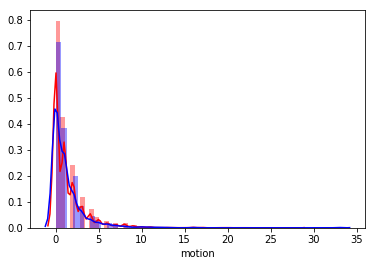

In [109]:
Variable = 'motion'
Delta_Score = All_Throwaway_replies[Variable].mean()- All_Pseud_replies[Variable].mean()
print('Delta is',Delta_Score)

print(ttest_ind(All_Throwaway_replies[Variable],All_Pseud_replies[Variable]))

import seaborn as sns
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.distplot(All_Throwaway_replies[Variable],kde='True', hist=True, label="Throwaway", color='red')
sns.distplot(All_Pseud_replies[Variable],kde='True', hist=True, label="Pseudonymous", color='blue')

Delta is 0.4167841705536488
Ttest_indResult(statistic=4.259922176548665, pvalue=2.0832552739164995e-05)


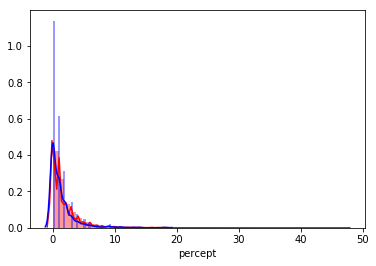

In [110]:
Variable = 'percept'
Delta_Score = All_Throwaway_replies[Variable].mean()- All_Pseud_replies[Variable].mean()
print('Delta is',Delta_Score)

print(ttest_ind(All_Throwaway_replies[Variable],All_Pseud_replies[Variable]))

import seaborn as sns
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.distplot(All_Throwaway_replies[Variable],kde='True', hist=True, label="Throwaway", color='red')
sns.distplot(All_Pseud_replies[Variable],kde='True', hist=True, label="Pseudonymous", color='blue')

Delta is 0.053002241381523485
Ttest_indResult(statistic=1.0561179912826197, pvalue=0.2909662935526019)


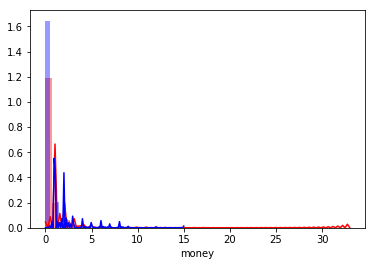

In [111]:
Variable = 'money'
Delta_Score = All_Throwaway_replies[Variable].mean()- All_Pseud_replies[Variable].mean()
print('Delta is',Delta_Score)

print(ttest_ind(All_Throwaway_replies[Variable],All_Pseud_replies[Variable]))

import seaborn as sns
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.distplot(All_Throwaway_replies[Variable],kde='True', hist=True, label="Throwaway", color='red')
sns.distplot(All_Pseud_replies[Variable],kde='True', hist=True, label="Pseudonymous", color='blue')

Delta is -0.0018194326439863046
Ttest_indResult(statistic=-0.13290646016712618, pvalue=0.89427280628623596)


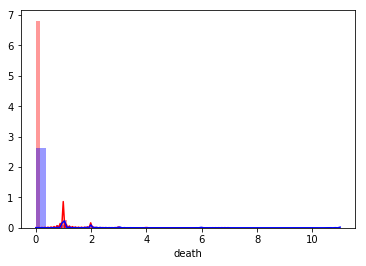

In [112]:
Variable = 'death'
Delta_Score = All_Throwaway_replies[Variable].mean()- All_Pseud_replies[Variable].mean()
print('Delta is',Delta_Score)

print(ttest_ind(All_Throwaway_replies[Variable],All_Pseud_replies[Variable]))

import seaborn as sns
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.distplot(All_Throwaway_replies[Variable],kde='True', hist=True, label="Throwaway", color='red')
sns.distplot(All_Pseud_replies[Variable],kde='True', hist=True, label="Pseudonymous", color='blue')

Delta is 0.20060077873465043
Ttest_indResult(statistic=1.6690215434108862, pvalue=0.095176889310554805)


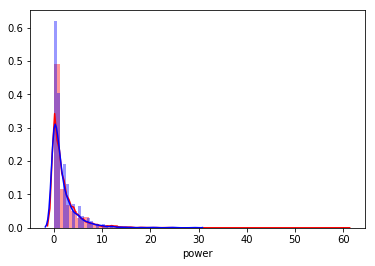

In [113]:
Variable = 'power'
Delta_Score = All_Throwaway_replies[Variable].mean()- All_Pseud_replies[Variable].mean()
print('Delta is',Delta_Score)

print(ttest_ind(All_Throwaway_replies[Variable],All_Pseud_replies[Variable]))

import seaborn as sns
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.distplot(All_Throwaway_replies[Variable],kde='True', hist=True, label="Throwaway", color='red')
sns.distplot(All_Pseud_replies[Variable],kde='True', hist=True, label="Pseudonymous", color='blue')

Delta is 0.12513173954092505
Ttest_indResult(statistic=1.1662604696120575, pvalue=0.24356581802528462)


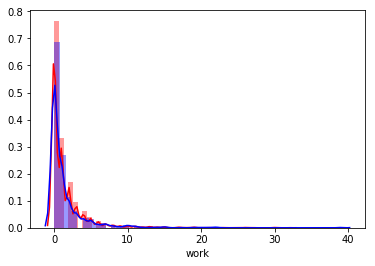

In [114]:
Variable = 'work'
Delta_Score = All_Throwaway_replies[Variable].mean()- All_Pseud_replies[Variable].mean()
print('Delta is',Delta_Score)

print(ttest_ind(All_Throwaway_replies[Variable],All_Pseud_replies[Variable]))

import seaborn as sns
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.distplot(All_Throwaway_replies[Variable],kde='True', hist=True, label="Throwaway", color='red')
sns.distplot(All_Pseud_replies[Variable],kde='True', hist=True, label="Pseudonymous", color='blue')

Delta is 0.03262415879916353
Ttest_indResult(statistic=1.650200817849248, pvalue=0.098965856249370099)


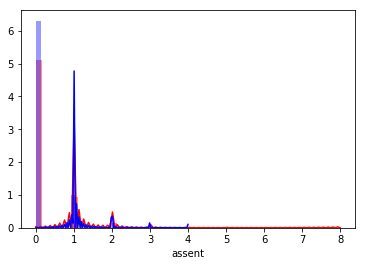

In [115]:
Variable = 'assent'
Delta_Score = All_Throwaway_replies[Variable].mean()- All_Pseud_replies[Variable].mean()
print('Delta is',Delta_Score)

print(ttest_ind(All_Throwaway_replies[Variable],All_Pseud_replies[Variable]))

import seaborn as sns
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.distplot(All_Throwaway_replies[Variable],kde='True', hist=True, label="Throwaway", color='red')
sns.distplot(All_Pseud_replies[Variable],kde='True', hist=True, label="Pseudonymous", color='blue')

Delta is 0.2396759760333036
Ttest_indResult(statistic=3.1631399891425729, pvalue=0.0015702961485412478)


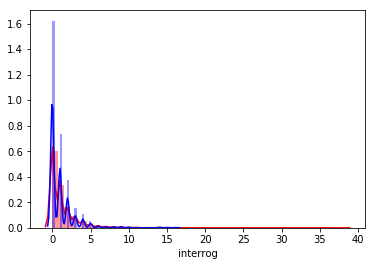

In [116]:
Variable = 'interrog'
Delta_Score = All_Throwaway_replies[Variable].mean()- All_Pseud_replies[Variable].mean()
print('Delta is',Delta_Score)

print(ttest_ind(All_Throwaway_replies[Variable],All_Pseud_replies[Variable]))

import seaborn as sns
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.distplot(All_Throwaway_replies[Variable],kde='True', hist=True, label="Throwaway", color='red')
sns.distplot(All_Pseud_replies[Variable],kde='True', hist=True, label="Pseudonymous", color='blue')

Delta is 0.2802980461172373
Ttest_indResult(statistic=3.3496387899319555, pvalue=0.00081527430578021479)


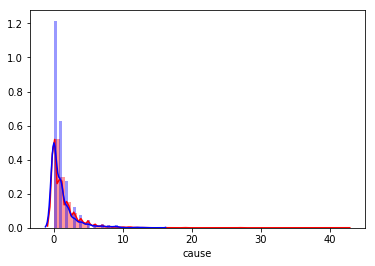

In [117]:
Variable = 'cause'
Delta_Score = All_Throwaway_replies[Variable].mean()- All_Pseud_replies[Variable].mean()
print('Delta is',Delta_Score)

print(ttest_ind(All_Throwaway_replies[Variable],All_Pseud_replies[Variable]))

import seaborn as sns
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.distplot(All_Throwaway_replies[Variable],kde='True', hist=True, label="Throwaway", color='red')
sns.distplot(All_Pseud_replies[Variable],kde='True', hist=True, label="Pseudonymous", color='blue')

Delta is 2.407986604693436
Ttest_indResult(statistic=4.5029760007801158, pvalue=6.8561365495997923e-06)


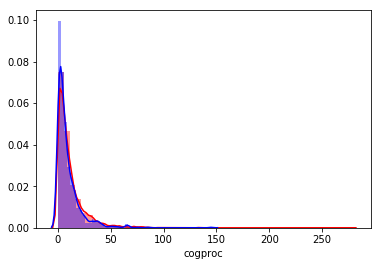

In [118]:
Variable = 'cogproc'
Delta_Score = All_Throwaway_replies[Variable].mean()- All_Pseud_replies[Variable].mean()
print('Delta is',Delta_Score)

print(ttest_ind(All_Throwaway_replies[Variable],All_Pseud_replies[Variable]))

import seaborn as sns
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.distplot(All_Throwaway_replies[Variable],kde='True', hist=True, label="Throwaway", color='red')
sns.distplot(All_Pseud_replies[Variable],kde='True', hist=True, label="Pseudonymous", color='blue')

Delta is 0.6543842673424405
Ttest_indResult(statistic=4.0536595384687013, pvalue=5.1203084047720109e-05)


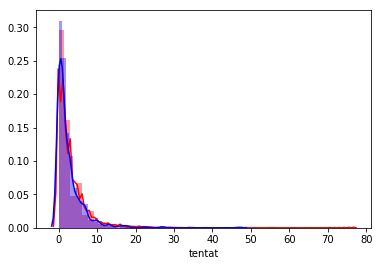

In [119]:
Variable = 'tentat'
Delta_Score = All_Throwaway_replies[Variable].mean()- All_Pseud_replies[Variable].mean()
print('Delta is',Delta_Score)

print(ttest_ind(All_Throwaway_replies[Variable],All_Pseud_replies[Variable]))

import seaborn as sns
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.distplot(All_Throwaway_replies[Variable],kde='True', hist=True, label="Throwaway", color='red')
sns.distplot(All_Pseud_replies[Variable],kde='True', hist=True, label="Pseudonymous", color='blue')

Delta is 0.2661323073284463
Ttest_indResult(statistic=2.5000269562288175, pvalue=0.012450766120815578)


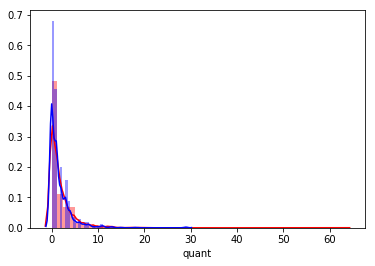

In [120]:
Variable = 'quant'
Delta_Score = All_Throwaway_replies[Variable].mean()- All_Pseud_replies[Variable].mean()
print('Delta is',Delta_Score)

print(ttest_ind(All_Throwaway_replies[Variable],All_Pseud_replies[Variable]))

import seaborn as sns
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.distplot(All_Throwaway_replies[Variable],kde='True', hist=True, label="Throwaway", color='red')
sns.distplot(All_Pseud_replies[Variable],kde='True', hist=True, label="Pseudonymous", color='blue')

Delta is 0.05953002268692131
Ttest_indResult(statistic=1.1063247561193086, pvalue=0.26864020314928372)


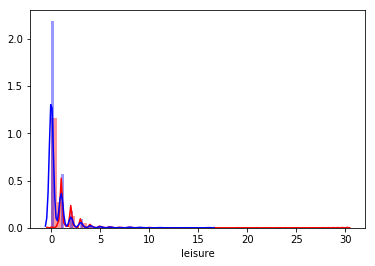

In [121]:
Variable = 'leisure'
Delta_Score = All_Throwaway_replies[Variable].mean()- All_Pseud_replies[Variable].mean()
print('Delta is',Delta_Score)

print(ttest_ind(All_Throwaway_replies[Variable],All_Pseud_replies[Variable]))

import seaborn as sns
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.distplot(All_Throwaway_replies[Variable],kde='True', hist=True, label="Throwaway", color='red')
sns.distplot(All_Pseud_replies[Variable],kde='True', hist=True, label="Pseudonymous", color='blue')

Delta is 0.2826683337061231
Ttest_indResult(statistic=4.1556393087711898, pvalue=3.2990030333040002e-05)


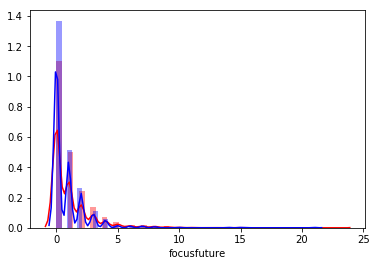

In [122]:
Variable = 'focusfuture'
Delta_Score = All_Throwaway_replies[Variable].mean()- All_Pseud_replies[Variable].mean()
print('Delta is',Delta_Score)

print(ttest_ind(All_Throwaway_replies[Variable],All_Pseud_replies[Variable]))

import seaborn as sns
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.distplot(All_Throwaway_replies[Variable],kde='True', hist=True, label="Throwaway", color='red')
sns.distplot(All_Pseud_replies[Variable],kde='True', hist=True, label="Pseudonymous", color='blue')

Delta is 0.47099436008653095
Ttest_indResult(statistic=3.986476320840231, pvalue=6.8035832321733408e-05)


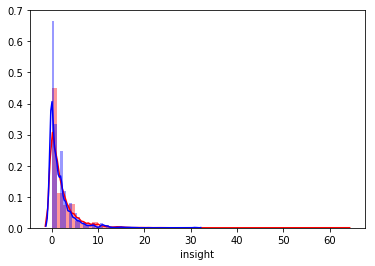

In [123]:
Variable = 'insight'
Delta_Score = All_Throwaway_replies[Variable].mean()- All_Pseud_replies[Variable].mean()
print('Delta is',Delta_Score)

print(ttest_ind(All_Throwaway_replies[Variable],All_Pseud_replies[Variable]))

import seaborn as sns
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.distplot(All_Throwaway_replies[Variable],kde='True', hist=True, label="Throwaway", color='red')
sns.distplot(All_Pseud_replies[Variable],kde='True', hist=True, label="Pseudonymous", color='blue')

Delta is 0.3379526494156486
Ttest_indResult(statistic=4.1130508212488968, pvalue=3.9685357308638335e-05)


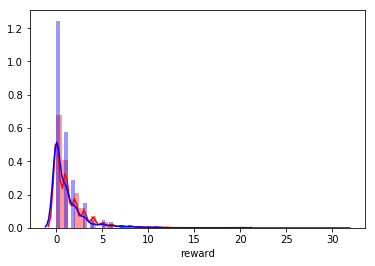

In [124]:
Variable = 'reward'
Delta_Score = All_Throwaway_replies[Variable].mean()- All_Pseud_replies[Variable].mean()
print('Delta is',Delta_Score)

print(ttest_ind(All_Throwaway_replies[Variable],All_Pseud_replies[Variable]))

import seaborn as sns
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.distplot(All_Throwaway_replies[Variable],kde='True', hist=True, label="Throwaway", color='red')
sns.distplot(All_Pseud_replies[Variable],kde='True', hist=True, label="Pseudonymous", color='blue')

Delta is 0.6027852449529316
Ttest_indResult(statistic=3.598399608594165, pvalue=0.00032333841857235023)


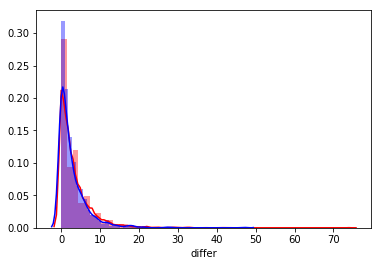

In [125]:
Variable = 'differ'
Delta_Score = All_Throwaway_replies[Variable].mean()- All_Pseud_replies[Variable].mean()
print('Delta is',Delta_Score)

print(ttest_ind(All_Throwaway_replies[Variable],All_Pseud_replies[Variable]))

import seaborn as sns
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.distplot(All_Throwaway_replies[Variable],kde='True', hist=True, label="Throwaway", color='red')
sns.distplot(All_Pseud_replies[Variable],kde='True', hist=True, label="Pseudonymous", color='blue')

Delta is 0.2025829825968617
Ttest_indResult(statistic=1.3131432462140351, pvalue=0.18919607263772059)


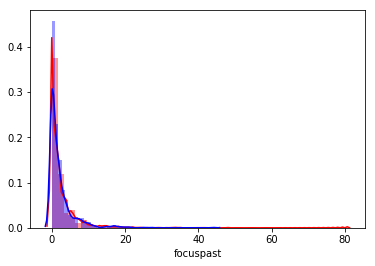

In [126]:
Variable = 'focuspast'
Delta_Score = All_Throwaway_replies[Variable].mean()- All_Pseud_replies[Variable].mean()
print('Delta is',Delta_Score)

print(ttest_ind(All_Throwaway_replies[Variable],All_Pseud_replies[Variable]))

import seaborn as sns
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.distplot(All_Throwaway_replies[Variable],kde='True', hist=True, label="Throwaway", color='red')
sns.distplot(All_Pseud_replies[Variable],kde='True', hist=True, label="Pseudonymous", color='blue')

Delta is 0.17564598461702752
Ttest_indResult(statistic=2.4458243038495988, pvalue=0.014487021646013761)


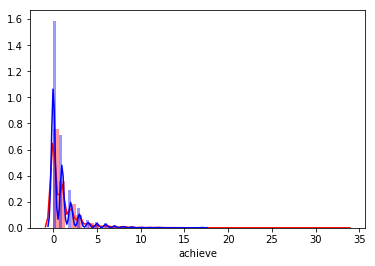

In [127]:
Variable = 'achieve'
Delta_Score = All_Throwaway_replies[Variable].mean()- All_Pseud_replies[Variable].mean()
print('Delta is',Delta_Score)

print(ttest_ind(All_Throwaway_replies[Variable],All_Pseud_replies[Variable]))

import seaborn as sns
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.distplot(All_Throwaway_replies[Variable],kde='True', hist=True, label="Throwaway", color='red')
sns.distplot(All_Pseud_replies[Variable],kde='True', hist=True, label="Pseudonymous", color='blue')

Delta is 0.1309456215771274
Ttest_indResult(statistic=3.0500464771913847, pvalue=0.0023002717025265278)


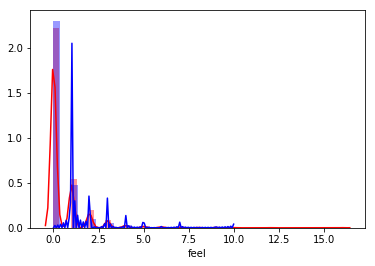

In [128]:
Variable = 'feel'
Delta_Score = All_Throwaway_replies[Variable].mean()- All_Pseud_replies[Variable].mean()
print('Delta is',Delta_Score)

print(ttest_ind(All_Throwaway_replies[Variable],All_Pseud_replies[Variable]))

import seaborn as sns
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.distplot(All_Throwaway_replies[Variable],kde='True', hist=True, label="Throwaway", color='red')
sns.distplot(All_Pseud_replies[Variable],kde='True', hist=True, label="Pseudonymous", color='blue')

Delta is 0.03214676938732197
Ttest_indResult(statistic=0.57803892391701572, pvalue=0.56326435958953813)


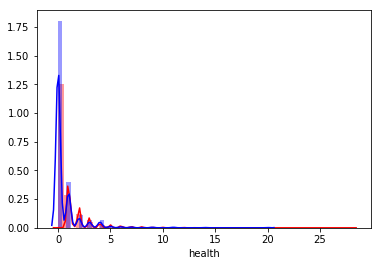

In [129]:
Variable = 'health'
Delta_Score = All_Throwaway_replies[Variable].mean()- All_Pseud_replies[Variable].mean()
print('Delta is',Delta_Score)

print(ttest_ind(All_Throwaway_replies[Variable],All_Pseud_replies[Variable]))

import seaborn as sns
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.distplot(All_Throwaway_replies[Variable],kde='True', hist=True, label="Throwaway", color='red')
sns.distplot(All_Pseud_replies[Variable],kde='True', hist=True, label="Pseudonymous", color='blue')

Delta is 0.30680626756584095
Ttest_indResult(statistic=3.3759451382188792, pvalue=0.00074133921664281831)


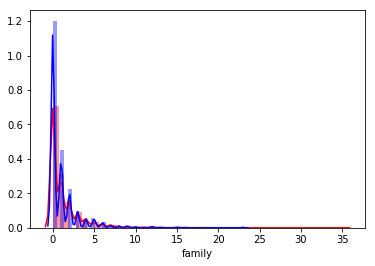

In [130]:
Variable = 'family'
Delta_Score = All_Throwaway_replies[Variable].mean()- All_Pseud_replies[Variable].mean()
print('Delta is',Delta_Score)

print(ttest_ind(All_Throwaway_replies[Variable],All_Pseud_replies[Variable]))

import seaborn as sns
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.distplot(All_Throwaway_replies[Variable],kde='True', hist=True, label="Throwaway", color='red')
sns.distplot(All_Pseud_replies[Variable],kde='True', hist=True, label="Pseudonymous", color='blue')

Delta is 0.6970177636381663
Ttest_indResult(statistic=5.1974983585334602, pvalue=2.1017722728830134e-07)


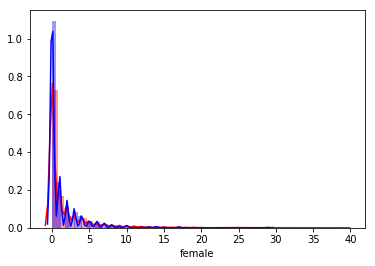

In [131]:
Variable = 'female'
Delta_Score = All_Throwaway_replies[Variable].mean()- All_Pseud_replies[Variable].mean()
print('Delta is',Delta_Score)

print(ttest_ind(All_Throwaway_replies[Variable],All_Pseud_replies[Variable]))

import seaborn as sns
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.distplot(All_Throwaway_replies[Variable],kde='True', hist=True, label="Throwaway", color='red')
sns.distplot(All_Pseud_replies[Variable],kde='True', hist=True, label="Pseudonymous", color='blue')

Delta is 0.11591959866516677
Ttest_indResult(statistic=2.6919484356968058, pvalue=0.0071276955886776837)


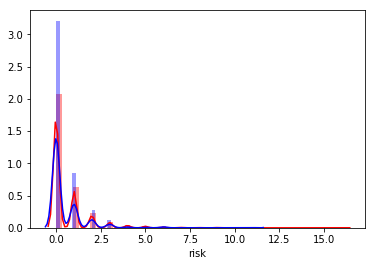

In [132]:
Variable = 'risk'
Delta_Score = All_Throwaway_replies[Variable].mean()- All_Pseud_replies[Variable].mean()
print('Delta is',Delta_Score)

print(ttest_ind(All_Throwaway_replies[Variable],All_Pseud_replies[Variable]))

import seaborn as sns
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.distplot(All_Throwaway_replies[Variable],kde='True', hist=True, label="Throwaway", color='red')
sns.distplot(All_Pseud_replies[Variable],kde='True', hist=True, label="Pseudonymous", color='blue')

Delta is 0.5212300369703688
Ttest_indResult(statistic=4.9198762296223721, pvalue=8.9429927037627496e-07)


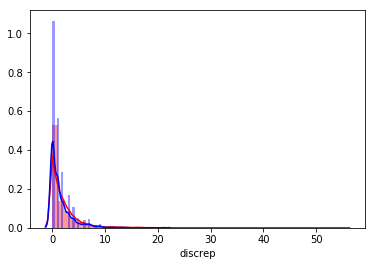

In [133]:
Variable = 'discrep'
Delta_Score = All_Throwaway_replies[Variable].mean()- All_Pseud_replies[Variable].mean()
print('Delta is',Delta_Score)

print(ttest_ind(All_Throwaway_replies[Variable],All_Pseud_replies[Variable]))

import seaborn as sns
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.distplot(All_Throwaway_replies[Variable],kde='True', hist=True, label="Throwaway", color='red')
sns.distplot(All_Pseud_replies[Variable],kde='True', hist=True, label="Pseudonymous", color='blue')

Delta is 0.24174284277747793
Ttest_indResult(statistic=3.2487607526081814, pvalue=0.0011668952659111326)


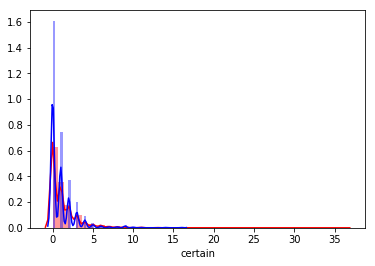

In [134]:
Variable = 'certain'
Delta_Score = All_Throwaway_replies[Variable].mean()- All_Pseud_replies[Variable].mean()
print('Delta is',Delta_Score)

print(ttest_ind(All_Throwaway_replies[Variable],All_Pseud_replies[Variable]))

import seaborn as sns
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.distplot(All_Throwaway_replies[Variable],kde='True', hist=True, label="Throwaway", color='red')
sns.distplot(All_Pseud_replies[Variable],kde='True', hist=True, label="Pseudonymous", color='blue')

Delta is 0.12341035197637301
Ttest_indResult(statistic=2.947368977122331, pvalue=0.0032199982892560739)


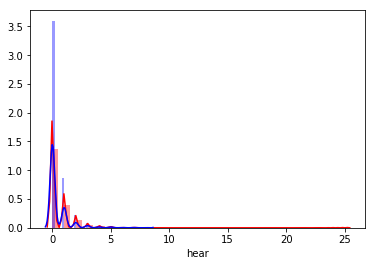

In [135]:
Variable = 'hear'
Delta_Score = All_Throwaway_replies[Variable].mean()- All_Pseud_replies[Variable].mean()
print('Delta is',Delta_Score)

print(ttest_ind(All_Throwaway_replies[Variable],All_Pseud_replies[Variable]))

import seaborn as sns
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.distplot(All_Throwaway_replies[Variable],kde='True', hist=True, label="Throwaway", color='red')
sns.distplot(All_Pseud_replies[Variable],kde='True', hist=True, label="Pseudonymous", color='blue')

Delta is 0.009596401117440811
Ttest_indResult(statistic=0.55755003731612407, pvalue=0.57717710904706587)


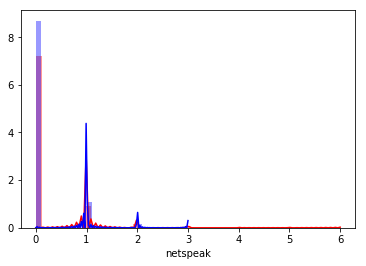

In [136]:
Variable = 'netspeak'
Delta_Score = All_Throwaway_replies[Variable].mean()- All_Pseud_replies[Variable].mean()
print('Delta is',Delta_Score)

print(ttest_ind(All_Throwaway_replies[Variable],All_Pseud_replies[Variable]))

import seaborn as sns
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.distplot(All_Throwaway_replies[Variable],kde='True', hist=True, label="Throwaway", color='red')
sns.distplot(All_Pseud_replies[Variable],kde='True', hist=True, label="Pseudonymous", color='blue')

Delta is -0.0308790110064478
Ttest_indResult(statistic=-0.77445826532630535, pvalue=0.43869714499637424)


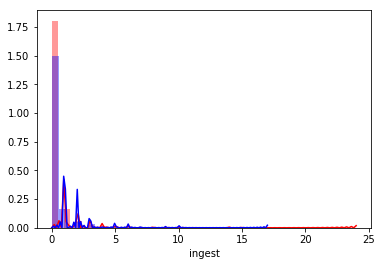

In [137]:
Variable = 'ingest'
Delta_Score = All_Throwaway_replies[Variable].mean()- All_Pseud_replies[Variable].mean()
print('Delta is',Delta_Score)

print(ttest_ind(All_Throwaway_replies[Variable],All_Pseud_replies[Variable]))

import seaborn as sns
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.distplot(All_Throwaway_replies[Variable],kde='True', hist=True, label="Throwaway", color='red')
sns.distplot(All_Pseud_replies[Variable],kde='True', hist=True, label="Pseudonymous", color='blue')

Delta is 0.03415846870518499
Ttest_indResult(statistic=1.4469639213646404, pvalue=0.14797089168864125)


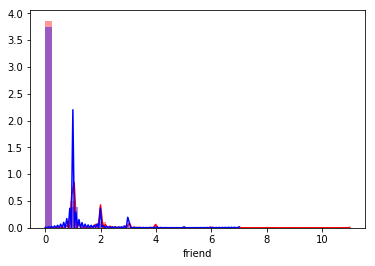

In [138]:
Variable = 'friend'
Delta_Score = All_Throwaway_replies[Variable].mean()- All_Pseud_replies[Variable].mean()
print('Delta is',Delta_Score)

print(ttest_ind(All_Throwaway_replies[Variable],All_Pseud_replies[Variable]))

import seaborn as sns
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.distplot(All_Throwaway_replies[Variable],kde='True', hist=True, label="Throwaway", color='red')
sns.distplot(All_Pseud_replies[Variable],kde='True', hist=True, label="Pseudonymous", color='blue')

Delta is 0.005414600960623295
Ttest_indResult(statistic=0.8370757094081801, pvalue=0.40259076931842697)


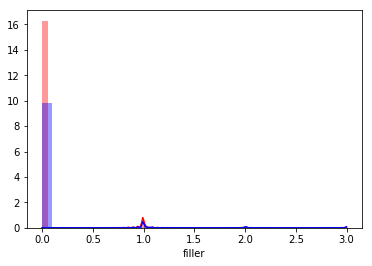

In [139]:
Variable = 'filler'
Delta_Score = All_Throwaway_replies[Variable].mean()- All_Pseud_replies[Variable].mean()
print('Delta is',Delta_Score)

print(ttest_ind(All_Throwaway_replies[Variable],All_Pseud_replies[Variable]))

import seaborn as sns
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.distplot(All_Throwaway_replies[Variable],kde='True', hist=True, label="Throwaway", color='red')
sns.distplot(All_Pseud_replies[Variable],kde='True', hist=True, label="Pseudonymous", color='blue')

Delta is 0.05802602755476391
Ttest_indResult(statistic=2.4607652202090105, pvalue=0.013898292403557479)


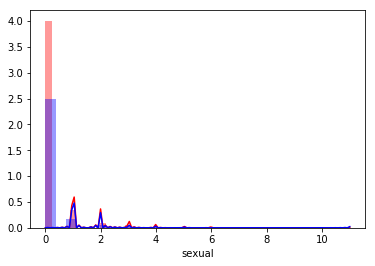

In [140]:
Variable = 'sexual'
Delta_Score = All_Throwaway_replies[Variable].mean()- All_Pseud_replies[Variable].mean()
print('Delta is',Delta_Score)

print(ttest_ind(All_Throwaway_replies[Variable],All_Pseud_replies[Variable]))

import seaborn as sns
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.distplot(All_Throwaway_replies[Variable],kde='True', hist=True, label="Throwaway", color='red')
sns.distplot(All_Pseud_replies[Variable],kde='True', hist=True, label="Pseudonymous", color='blue')

Delta is 0.16640325586133414
Ttest_indResult(statistic=3.481452414872483, pvalue=0.00050304692996745227)


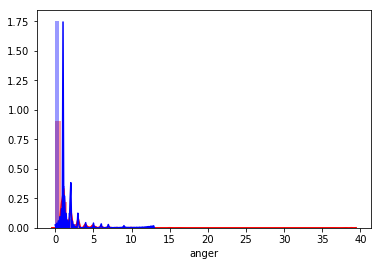

In [141]:
Variable = 'anger'
Delta_Score = All_Throwaway_replies[Variable].mean()- All_Pseud_replies[Variable].mean()
print('Delta is',Delta_Score)

print(ttest_ind(All_Throwaway_replies[Variable],All_Pseud_replies[Variable]))

import seaborn as sns
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.distplot(All_Throwaway_replies[Variable],kde='True', hist=True, label="Throwaway", color='red')
sns.distplot(All_Pseud_replies[Variable],kde='True', hist=True, label="Pseudonymous", color='blue')

Delta is 0.841094325101643
Ttest_indResult(statistic=5.0936762793742245, pvalue=3.6433841228847915e-07)


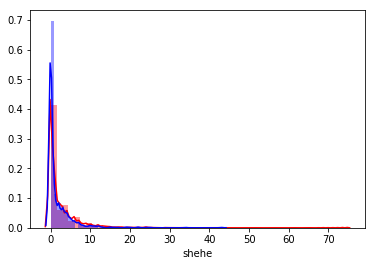

In [142]:
Variable = 'shehe'
Delta_Score = All_Throwaway_replies[Variable].mean()- All_Pseud_replies[Variable].mean()
print('Delta is',Delta_Score)

print(ttest_ind(All_Throwaway_replies[Variable],All_Pseud_replies[Variable]))

import seaborn as sns
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.distplot(All_Throwaway_replies[Variable],kde='True', hist=True, label="Throwaway", color='red')
sns.distplot(All_Pseud_replies[Variable],kde='True', hist=True, label="Pseudonymous", color='blue')

Delta is 0.30416178148182427
Ttest_indResult(statistic=1.6071228790346099, pvalue=0.10809174093933498)


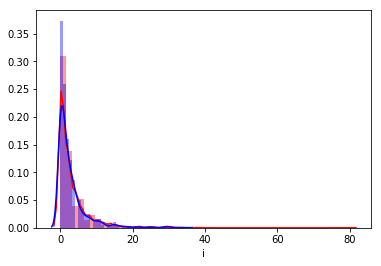

In [143]:
Variable = 'i'
Delta_Score = All_Throwaway_replies[Variable].mean()- All_Pseud_replies[Variable].mean()
print('Delta is',Delta_Score)

print(ttest_ind(All_Throwaway_replies[Variable],All_Pseud_replies[Variable]))

import seaborn as sns
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.distplot(All_Throwaway_replies[Variable],kde='True', hist=True, label="Throwaway", color='red')
sns.distplot(All_Pseud_replies[Variable],kde='True', hist=True, label="Pseudonymous", color='blue')

Delta is 0.000893603063813142
Ttest_indResult(statistic=0.012004484867881606, pvalue=0.99042252481654081)


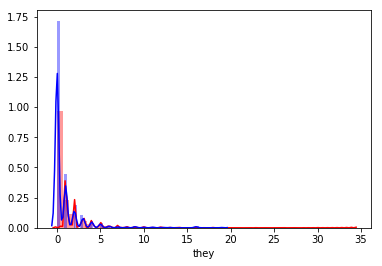

In [144]:
Variable = 'they'
Delta_Score = All_Throwaway_replies[Variable].mean()- All_Pseud_replies[Variable].mean()
print('Delta is',Delta_Score)

print(ttest_ind(All_Throwaway_replies[Variable],All_Pseud_replies[Variable]))

import seaborn as sns
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.distplot(All_Throwaway_replies[Variable],kde='True', hist=True, label="Throwaway", color='red')
sns.distplot(All_Pseud_replies[Variable],kde='True', hist=True, label="Pseudonymous", color='blue')

Delta is 1.0752196933510416
Ttest_indResult(statistic=6.3863279181174981, pvalue=1.8561342581127121e-10)


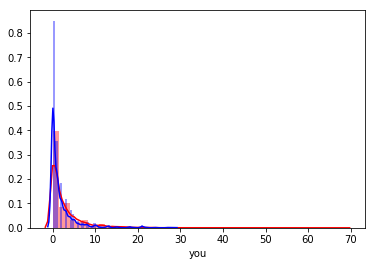

In [145]:
Variable = 'you'
Delta_Score = All_Throwaway_replies[Variable].mean()- All_Pseud_replies[Variable].mean()
print('Delta is',Delta_Score)

print(ttest_ind(All_Throwaway_replies[Variable],All_Pseud_replies[Variable]))

import seaborn as sns
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.distplot(All_Throwaway_replies[Variable],kde='True', hist=True, label="Throwaway", color='red')
sns.distplot(All_Pseud_replies[Variable],kde='True', hist=True, label="Pseudonymous", color='blue')

Delta is 3.0681896699813542
Ttest_indResult(statistic=5.3517400541582294, pvalue=9.1075825993407918e-08)


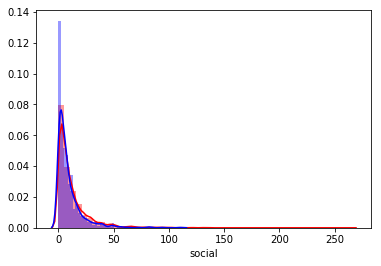

In [146]:
Variable = 'social'
Delta_Score = All_Throwaway_replies[Variable].mean()- All_Pseud_replies[Variable].mean()
print('Delta is',Delta_Score)

print(ttest_ind(All_Throwaway_replies[Variable],All_Pseud_replies[Variable]))

import seaborn as sns
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.distplot(All_Throwaway_replies[Variable],kde='True', hist=True, label="Throwaway", color='red')
sns.distplot(All_Pseud_replies[Variable],kde='True', hist=True, label="Pseudonymous", color='blue')